# Improving What's Cooking Using GNNs to redefine Culinary Boundaries


## Configuration de l'Environnement


In [1]:
import torch
from torch import Tensor
import numpy as np
import pandas as pd

print(f"Version de PyTorch: {torch.__version__}")

Version de PyTorch: 2.2.2+cpu


### Installation de PyTorch Geometric


In [2]:
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/pyg-team/pytorch_geometri

### Import des bibliothèques

In [3]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

---
## Chargement et Exploration des Donnée

Le **FlavorGraph** est un graphe de connaissances culinaires qui contient :
- Des **nœuds** : ingrédients, recettes, composés chimiques
- Des **arêtes** : relations entre ces éléments avec un score de compatibilité

Pour ce projet, on se concentre uniquement sur les relations **ingrédient-ingrédient**.

### Chargement des arêtes (edges)

Chaque arête représente une relation entre deux éléments avec :
- `id_1`, `id_2` : identifiants des nœuds connectés
- `edge_type` : type de relation
- `score` : force de la relation (0-1)

In [4]:
edge_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv"
edges_df = pd.read_csv(edge_url)

print("Distribution des types d'arêtes:")
print(edges_df.edge_type.value_counts())
print(f"\nNombre total d'arêtes: {len(edges_df)}")

edges_df.head()

Distribution des types d'arêtes:
edge_type
ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: count, dtype: int64

Nombre total d'arêtes: 147179


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Filtrage : uniquement les relations ingrédient-ingrédient

On ne garde que les 111,355 premières lignes qui correspondent aux relations ingrédient-ingrédient (`entity_entity`). Cela simplifie le problème et se concentre sur les paires d'ingrédients.

In [5]:
# Filtrer uniquement les relations entity_entity (ingrédient-ingrédient)
edges_df = edges_df.iloc[:111355, :]

print("Après filtrage:")
print(edges_df.edge_type.value_counts())
print(f"\nAperçu des données:")
edges_df.head()

Après filtrage:
edge_type
ingr-ingr    111355
Name: count, dtype: int64

Aperçu des données:


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Chargement des nœuds (nodes)

Chaque nœud contient :
- `node_id` : identifiant unique
- `name` : nom de l'ingrédient/recette/composé
- `node_type` : type du nœud

In [6]:
node_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv"
nodes_df = pd.read_csv(node_url)

print(f"Forme du DataFrame: {nodes_df.shape}")
print("\nAperçu des nœuds:")
nodes_df.head()

Forme du DataFrame: (8298, 5)

Aperçu des nœuds:


,node_id,name,id,node_type,is_hub
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub
2,3,10%_cream,NaN,ingredient,no_hub
3,4,100%_bran,NaN,ingredient,no_hub
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub


### Analyse des types de nœuds

In [7]:
print("Distribution des types de nœuds:")
nodes_df.node_type.value_counts()

Distribution des types de nœuds:


node_type
ingredient    6653
compound      1645
Name: count, dtype: int64

### Filtrage des nœuds pertinents

On ne garde que les nœuds (ingrédients) qui apparaissent dans nos arêtes filtrées.

In [8]:
# Récupérer tous les IDs uniques présents dans les arêtes
relevant_node_ids = set(edges_df.id_1.values).union(set(edges_df.id_2.values))

# Filtrer le DataFrame des nœuds
nodes_df = nodes_df[nodes_df['node_id'].isin(relevant_node_ids)]

print(f"Nombre de nœuds après filtrage: {len(nodes_df)}")
print("\nTypes de nœuds restants:")
nodes_df.node_type.value_counts()

Nombre de nœuds après filtrage: 6653

Types de nœuds restants:


node_type
ingredient    6653
Name: count, dtype: int64

---
## Construction du Graphe

On construit maintenant un objet `Data` de PyTorch Geometric qui représente notre graphe.

### Étapes :
1. Créer un mapping des IDs de nœuds vers des indices contigus (0, 1, 2, ...)
2. Convertir les arêtes en format PyTorch (tenseurs)
3. Créer un graphe non-orienté (undirected)
4. Diviser en ensembles train/validation/test

In [9]:
# Initialisation du graphe
flavorGraph = Data()

# Extraction des poids des arêtes
edge_weight = torch.Tensor(edges_df.score.values)

# Extraction des indices de nœuds
node_index = torch.Tensor(nodes_df.node_id.values)

# Création d'un mapping : node_id -> index continu
node_map = dict()
for i in range(len(node_index)):
    node_map[int(node_index[i])] = i

print(f"Nombre de nœuds: {len(node_map)}")
print(f"Exemple de mapping: {list(node_map.items())[:5]}")

Nombre de nœuds: 6653
Exemple de mapping: [(0, 0), (1, 1), (3, 2), (4, 3), (5, 4)]


### Création de la matrice d'adjacence

Format PyG : `edge_index` est une matrice 2×N où chaque colonne est une arête [source, destination]

In [10]:
# Conversion des IDs d'arêtes vers les indices mappés
edge_index = torch.Tensor([
    edges_df.id_1.apply(lambda x: node_map[x]).values,
    edges_df.id_2.apply(lambda x: node_map[x]).values
])

# Construction du graphe
flavorGraph.x = node_index.view(node_index.size(0), -1)  # Features = node_id
flavorGraph.edge_index = edge_index.type(torch.int64)
flavorGraph.edge_weight = edge_weight

# Validation du graphe
flavorGraph.validate(raise_on_error=True)

# Conversion en graphe non-orienté
flavorGraph = ToUndirected()(flavorGraph)
print(f"Graphe non-orienté: {flavorGraph.is_undirected()}")
print(f"\nStatistiques du graphe:")
print(f"  - Nœuds: {flavorGraph.num_nodes}")
print(f"  - Arêtes: {flavorGraph.num_edges}")
print(f"  - Features par nœud: {flavorGraph.num_node_features}")

Graphe non-orienté: True

Statistiques du graphe:
  - Nœuds: 6653
  - Arêtes: 222710
  - Features par nœud: 1


/tmp/ipykernel_29218/3774677864.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.Tensor([


### Division Train/Validation/Test

**RandomLinkSplit** divise les arêtes du graphe en trois ensembles :
- **Train** : pour entraîner le modèle
- **Validation** : pour ajuster les hyperparamètres
- **Test** : pour évaluer les performances finales

Paramètres :
- `is_undirected=True` : graphe non-orienté
- `add_negative_train_samples=False` : on générera les samples négatifs nous-mêmes
- `disjoint_train_ratio=0.35` : 35% des arêtes pour validation/test

In [11]:
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.35
)

train_data, val_data, test_data = transform(flavorGraph)

### Aperçu des données d'entraînement

In [12]:
print("Structure de train_data:")
print(train_data)
print("\nStructure de val_data:")
print(val_data)
print("\nStructure de test_data:")
print(test_data)

Structure de train_data:
Data(x=[6653, 1], edge_index=[2, 101334], edge_weight=[101334], edge_label=[27282], edge_label_index=[2, 27282])

Structure de val_data:
Data(x=[6653, 1], edge_index=[2, 155898], edge_weight=[155898], edge_label=[22270], edge_label_index=[2, 22270])

Structure de test_data:
Data(x=[6653, 1], edge_index=[2, 178168], edge_weight=[178168], edge_label=[44542], edge_label_index=[2, 44542])


---
## Modèle GCN (Graph Convolutional Network)

### Architecture du modèle

Le **GCN** fonctionne en deux étapes :

1. **Encodage** : Deux couches de convolution sur graphe qui agrègent les informations des voisins
   - Couche 1 : `num_features → 128 dimensions`
   - Couche 2 : `128 → 64 dimensions` (embeddings finaux)

2. **Décodage** : Prédit la probabilité d'existence d'une arête par produit scalaire des embeddings
   - Si `z[i] · z[j]` est élevé → l'arête (i,j) existe probablement

### Fonctions clés
- `encode()` : transforme le graphe en embeddings
- `decode()` : prédit des arêtes à partir des embeddings
- `decode_all()` : calcule toutes les probabilités d'arêtes possibles

In [13]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Deux couches de convolution sur graphe
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        """Encode le graphe en embeddings de dimension out_channels"""
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        """Prédit la probabilité d'arêtes spécifiques via produit scalaire"""
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        """Calcule la matrice complète de probabilités d'arêtes"""
        prob_adj = z @ z.t()  # Produit matriciel : NxD × DxN = NxN
        prob_adj = torch.sigmoid(prob_adj)  # Conversion en probabilités [0,1]
        return prob_adj

model = Net(flavorGraph.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Fonctions d'entraînement et d'évaluation

**Entraînement** :
1. Encode le graphe
2. Génère des arêtes négatives (échantillonnage aléatoire)
3. Calcule la loss sur arêtes positives + négatives
4. Backpropagation et mise à jour des poids

**Évaluation** :
- Métrique : **ROC-AUC** (Area Under ROC Curve)
- Mesure la capacité à distinguer arêtes existantes vs. inexistantes

In [14]:
def train():
    model.train()
    optimizer.zero_grad()
    
    # Encodage du graphe
    z = model.encode(train_data.x, train_data.edge_index)

    # Échantillonnage négatif : génère des arêtes qui n'existent pas
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1),
        method='sparse'
    )

    # Concaténation arêtes positives + négatives
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # Prédiction et calcul de la loss
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    return loss

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

# Création du modèle GCN
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

model_gcn = Net(flavorGraph.num_features, 128, 64)
model = model_gcn  # Keep reference for compatibility
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GCN

On entraîne pendant **150 epochs** et on sauvegarde :
- Les métriques de validation et test à chaque epoch
- Le meilleur modèle basé sur la validation
- Les probabilités finales pour toutes les paires d'ingrédients

In [15]:
validationMetrics_GCN = []
best_val_auc = 0
final_test_auc = 0

for epoch in range(0, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    # Sauvegarde du meilleur modèle
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GCN.append([val_auc, test_auc])
    
    # Affichage tous les 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

# Calcul des probabilités finales
z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_GCN = model.decode_all(z)

Epoch: 000, Loss: 3072695.2500, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 143395.0156, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 143395.0156, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 43154.9883, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 43154.9883, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 17453.5410, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 17453.5410, Val: 0.5000, Test: 0.5000
Epoch: 040, Loss: 3507.0110, Val: 0.5000, Test: 0.5000
Epoch: 040, Loss: 3507.0110, Val: 0.5000, Test: 0.5000
Epoch: 050, Loss: 1821.8376, Val: 0.5000, Test: 0.5000
Epoch: 050, Loss: 1821.8376, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 594.1235, Val: 0.5001, Test: 0.5000
Epoch: 060, Loss: 594.1235, Val: 0.5001, Test: 0.5000
Epoch: 070, Loss: 152.0499, Val: 0.5002, Test: 0.5003
Epoch: 070, Loss: 152.0499, Val: 0.5002, Test: 0.5003
Epoch: 080, Loss: 92.1136, Val: 0.5005, Test: 0.5005
Epoch: 080, Loss: 92.1136, Val: 0.5005, Test: 0.5005
Epoch: 090, Loss: 24.0842, Val: 0.5201, Test: 0.5209
Epoch: 09

### Visualisation des performances GCN

Courbe d'évolution du **Test AUC** au fil des epochs.

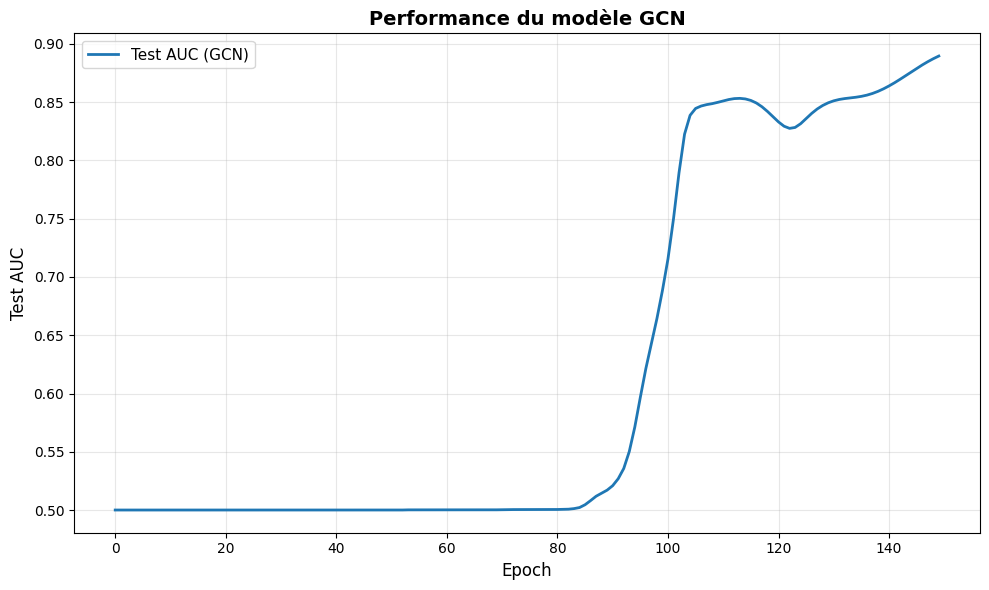

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='Test AUC (GCN)', 
         linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GCN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GCN)

On part d'un ingrédient aléatoire et on suit les liens les plus probables pour créer une "recette" de 2-6 ingrédients.

In [17]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GCN:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    # Top 10 ingrédients les plus compatibles
    top_nodes = nodes_df.iloc[final_edge_probs_GCN.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GCN:
Ingrédient de départ: cooked_noodle

  1. butter
  2. garlic_clove


---
## Modèle GraphSAGE

### Différences avec GCN

**GraphSAGE** (SAmple and aggreGatE) diffère du GCN par :
1. **Échantillonnage** : ne considère qu'un sous-ensemble de voisins (scalabilité)
2. **Agrégation** : plus flexible (mean, max, LSTM, etc.)

Dans PyG, `SAGEConv` utilise l'agrégation par moyenne.

In [18]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Remplacement des couches GCN par SAGEConv
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GraphSAGE

Même architecture que GCN : 1 → 128 → 64

In [19]:
model_sage = Net(flavorGraph.num_features, 128, 64)
model = model_sage  # Keep reference for compatibility
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GraphSAGE

Même procédure que pour GCN : 150 epochs avec suivi des métriques.

In [20]:
validationMetrics_SAGE = []
best_val_auc = final_test_auc = 0


for epoch in range(0, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_SAGE.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_SAGE = model.decode_all(z)

Epoch: 000, Loss: 64541700.0000, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 22294334.0000, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 22294334.0000, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 3366781.5000, Val: 0.5080, Test: 0.5057
Epoch: 020, Loss: 3366781.5000, Val: 0.5080, Test: 0.5057
Epoch: 030, Loss: 1569885.8750, Val: 0.5138, Test: 0.5109
Epoch: 030, Loss: 1569885.8750, Val: 0.5138, Test: 0.5109
Epoch: 040, Loss: 739063.9375, Val: 0.5242, Test: 0.5186
Epoch: 040, Loss: 739063.9375, Val: 0.5242, Test: 0.5186
Epoch: 050, Loss: 299573.0938, Val: 0.5280, Test: 0.5228
Epoch: 050, Loss: 299573.0938, Val: 0.5280, Test: 0.5228
Epoch: 060, Loss: 169298.0312, Val: 0.5358, Test: 0.5336
Epoch: 060, Loss: 169298.0312, Val: 0.5358, Test: 0.5336
Epoch: 070, Loss: 110494.4531, Val: 0.5425, Test: 0.5348
Epoch: 070, Loss: 110494.4531, Val: 0.5425, Test: 0.5348
Epoch: 080, Loss: 81931.4219, Val: 0.5417, Test: 0.5329
Epoch: 080, Loss: 81931.4219, Val: 0.5417, Test: 0.5329
Epoch: 090, Loss: 60400

### Visualisation des performances GraphSAGE

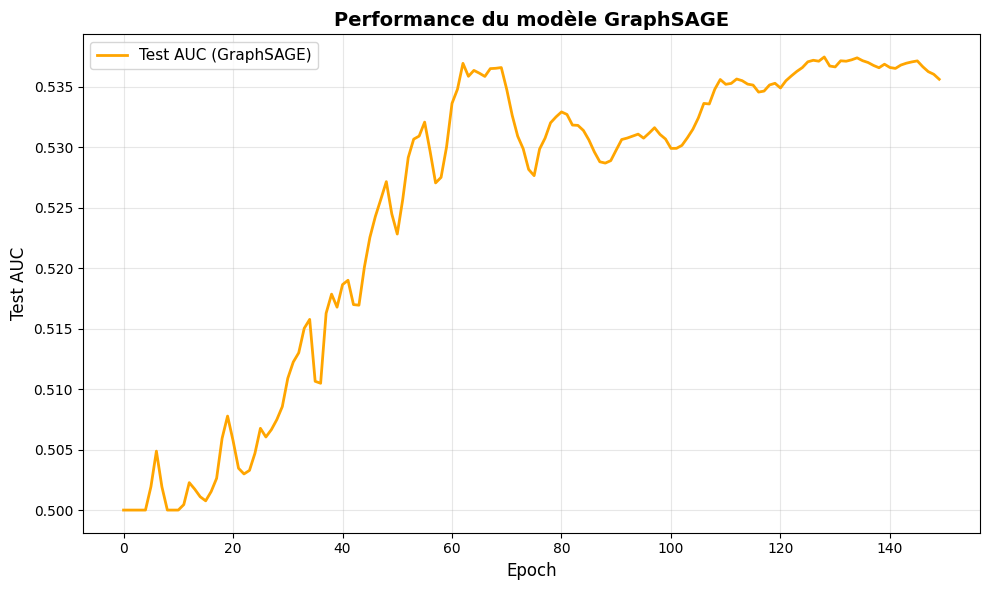

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='Test AUC (GraphSAGE)', 
         linewidth=2,
         color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GraphSAGE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GraphSAGE)

In [22]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GraphSAGE:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_SAGE.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GraphSAGE:
Ingrédient de départ: prepared_graham_cracker_crust

  1. 2%_buttermilk
  2. 18%_table_cream
  3. 10_inch_flour_tortilla
  4. 12_inch_pizza_crust
  5. 1%_fat_buttermilk
  6. 10_inch_flour_tortilla


---
## Comparaison des Modèles

Comparons visuellement les performances de **GCN** et **GraphSAGE** sur l'ensemble de test.

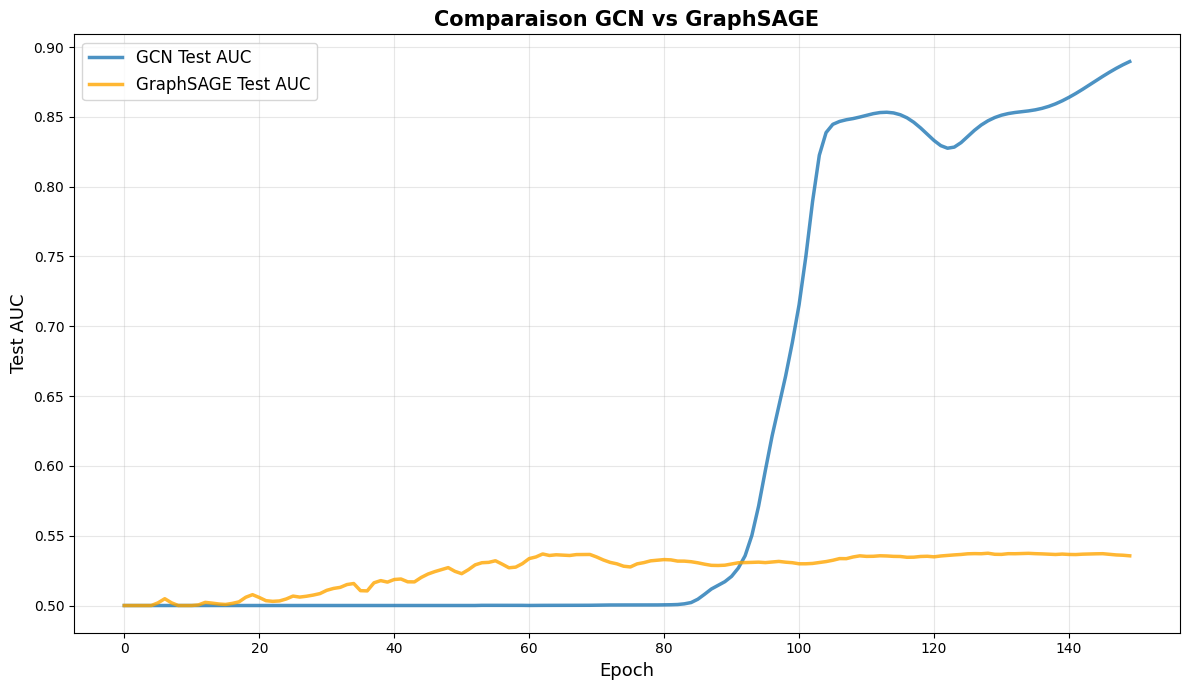


Résultats Finaux:
  GCN Test AUC:        0.8896
  GraphSAGE Test AUC:  0.5356
  Différence:          0.3540

GCN performe mieux de 66.10%


In [23]:
plt.figure(figsize=(12, 7))

plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='GCN Test AUC', 
         linewidth=2.5,
         alpha=0.8)

plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='GraphSAGE Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='orange')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Test AUC', fontsize=13)
plt.title('Comparaison GCN vs GraphSAGE', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques finales
gcn_final = np.array(validationMetrics_GCN)[-1, 1]
sage_final = np.array(validationMetrics_SAGE)[-1, 1]

print("\nRésultats Finaux:")
print(f"  GCN Test AUC:        {gcn_final:.4f}")
print(f"  GraphSAGE Test AUC:  {sage_final:.4f}")
print(f"  Différence:          {abs(gcn_final - sage_final):.4f}")

if gcn_final > sage_final:
    print(f"\nGCN performe mieux de {((gcn_final - sage_final) / sage_final * 100):.2f}%")
else:
    print(f"\nGraphSAGE performe mieux de {((sage_final - gcn_final) / gcn_final * 100):.2f}%")

---
## Modèle GAT (Graph Attention Network)

### Mécanisme d'attention

**GAT** introduit un mécanisme d'**attention** qui permet au modèle d'apprendre l'importance de chaque voisin :
1. **Poids d'attention** : calcule un score pour chaque voisin
2. **Agrégation pondérée** : combine les informations en fonction de ces scores
3. **Multi-head attention** : utilise plusieurs mécanismes d'attention en parallèle pour capturer différents patterns

Avantages par rapport à GCN :
- Adaptabilité : pondération dynamique des voisins
- Interprétabilité : les poids d'attention révèlent les relations importantes
- Performance : souvent meilleure sur des graphes complexes

In [24]:
# Normalisation des features pour GAT et GIN
train_data_norm = train_data.clone()
val_data_norm = val_data.clone()
test_data_norm = test_data.clone()

mean = train_data.x.mean(dim=0, keepdim=True)
std = train_data.x.std(dim=0, keepdim=True)

train_data_norm.x = (train_data.x - mean) / (std + 1e-10)
val_data_norm.x = (val_data.x - mean) / (std + 1e-10)
test_data_norm.x = (test_data.x - mean) / (std + 1e-10)

print(f'Features normalisées: mean={train_data_norm.x.mean():.4f}, std={train_data_norm.x.std():.4f}')

Features normalisées: mean=-0.0000, std=1.0000


In [25]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        # Couches GAT avec Batch Normalization
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(heads * hidden_channels)
        
        self.conv2 = GATConv(heads * hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GAT

Même architecture de base : 1 → 128 → 64, mais avec mécanisme d'attention multi-têtes.

In [26]:
model_gat = Net(flavorGraph.num_features, 128, 64, heads=4, dropout=0.3)
model = model_gat  # Keep reference for compatibility
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GAT

150 epochs avec mécanisme d'attention pour apprendre les pondérations optimales.

In [27]:
def train_gat():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data_norm.x, train_data_norm.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_norm.edge_index, num_nodes=train_data_norm.num_nodes,
                                       num_neg_samples=train_data_norm.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data_norm.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_norm.edge_label, train_data_norm.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

validationMetrics_GAT = []
best_val_auc = final_test_auc = 0

for epoch in range(0, 150):
    loss = train_gat()
    val_auc = test(val_data_norm)
    test_auc = test(test_data_norm)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GAT.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data_norm.x, test_data_norm.edge_index)
final_edge_probs_GAT = model.decode_all(z)

Epoch: 000, Loss: 2.2512, Val: 0.3480, Test: 0.3426
Epoch: 010, Loss: 1.0627, Val: 0.3251, Test: 0.3186
Epoch: 010, Loss: 1.0627, Val: 0.3251, Test: 0.3186
Epoch: 020, Loss: 0.8678, Val: 0.3174, Test: 0.3108
Epoch: 020, Loss: 0.8678, Val: 0.3174, Test: 0.3108
Epoch: 030, Loss: 0.9077, Val: 0.2951, Test: 0.2904
Epoch: 030, Loss: 0.9077, Val: 0.2951, Test: 0.2904
Epoch: 040, Loss: 0.8432, Val: 0.3585, Test: 0.3448
Epoch: 040, Loss: 0.8432, Val: 0.3585, Test: 0.3448
Epoch: 050, Loss: 0.7881, Val: 0.5323, Test: 0.5072
Epoch: 050, Loss: 0.7881, Val: 0.5323, Test: 0.5072
Epoch: 060, Loss: 0.8179, Val: 0.5845, Test: 0.5657
Epoch: 060, Loss: 0.8179, Val: 0.5845, Test: 0.5657
Epoch: 070, Loss: 0.8131, Val: 0.4209, Test: 0.3882
Epoch: 070, Loss: 0.8131, Val: 0.4209, Test: 0.3882
Epoch: 080, Loss: 0.7526, Val: 0.5367, Test: 0.5080
Epoch: 080, Loss: 0.7526, Val: 0.5367, Test: 0.5080
Epoch: 090, Loss: 0.7932, Val: 0.4928, Test: 0.4694
Epoch: 090, Loss: 0.7932, Val: 0.4928, Test: 0.4694
Epoch: 100, 

### Visualisation des performances GAT

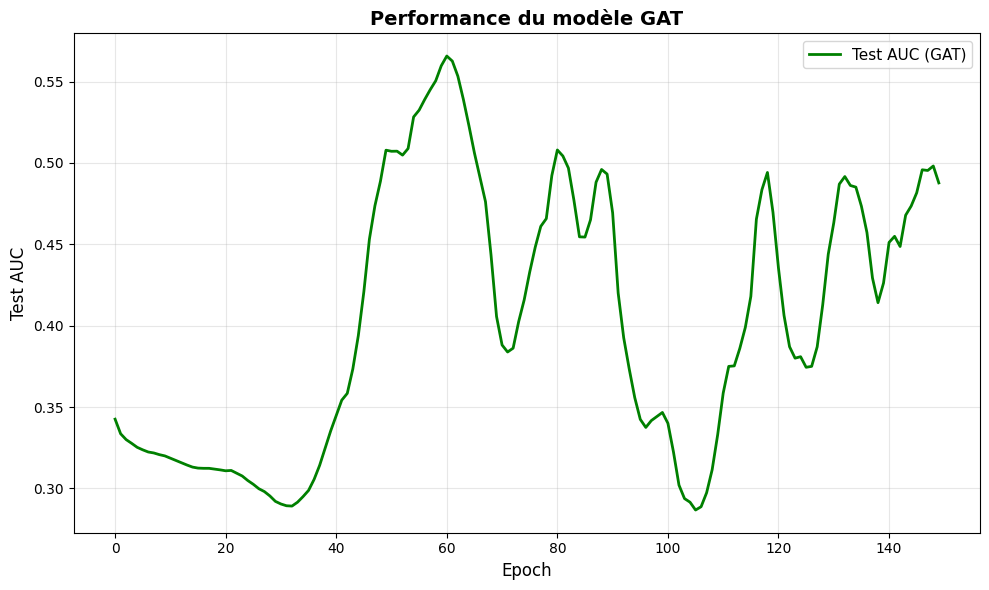

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GAT)), 
         np.array(validationMetrics_GAT)[:, 1], 
         label='Test AUC (GAT)', 
         linewidth=2,
         color='green')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GAT', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GAT)

In [29]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GAT:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_GAT.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GAT:
Ingrédient de départ: tawny_port

  1. chocolate_truffle
  2. beef_gravy_mix


---
## Modèle GIN (Graph Isomorphism Network)

### Mécanisme du GIN

**GIN** est basé sur le théorème du Weisfeiler-Lehman (WL) et maximise le pouvoir expressif des GNN :
1. **Agrégation injective** : utilise une fonction qui préserve l'information complète des voisins
2. **MLP** : applique un perceptron multicouche pour transformer les embeddings
3. **Expressivité** : capable de distinguer plus de structures de graphes que GCN ou GraphSAGE

Formule : `h^(k) = MLP^(k)((1 + ε^(k)) · h^(k-1) + SUM(h_j^(k-1)))` où ε est appris.

Avantages :
- Pouvoir discriminatif maximal parmi les GNN par passage de messages
- Capture les motifs structurels complexes
- Théoriquement aussi puissant que le test WL

In [30]:
from torch_geometric.nn import GINConv
from torch.nn import Sequential, Linear, ReLU
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        
        # MLP avec Batch Normalization pour la première couche
        nn1 = Sequential(
            Linear(in_channels, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
            ReLU(),
            torch.nn.Dropout(dropout),
            Linear(hidden_channels, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels)
        )
        self.conv1 = GINConv(nn1, train_eps=False)
        
        # MLP avec Batch Normalization pour la seconde couche
        nn2 = Sequential(
            Linear(hidden_channels, out_channels),
            torch.nn.BatchNorm1d(out_channels),
            ReLU(),
            torch.nn.Dropout(dropout),
            Linear(out_channels, out_channels),
            torch.nn.BatchNorm1d(out_channels)
        )
        self.conv2 = GINConv(nn2, train_eps=False)
        
        # Initialisation Xavier
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GIN

Architecture : 1 → 128 → 64 avec MLPs intégrés dans les couches GIN.

In [31]:
model_gin = Net(flavorGraph.num_features, 128, 64, dropout=0.3)
model = model_gin  # Keep reference for compatibility
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GIN

150 epochs avec agrégation injective pour maximiser l'expressivité.

In [32]:
def train_gin():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data_norm.x, train_data_norm.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_norm.edge_index, num_nodes=train_data_norm.num_nodes,
                                       num_neg_samples=train_data_norm.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data_norm.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_norm.edge_label, train_data_norm.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

validationMetrics_GIN = []
best_val_auc = final_test_auc = 0

for epoch in range(0, 150):
    loss = train_gin()
    val_auc = test(val_data_norm)
    test_auc = test(test_data_norm)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GIN.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data_norm.x, test_data_norm.edge_index)
final_edge_probs_GIN = model.decode_all(z)

Epoch: 000, Loss: 8.0810, Val: 0.5548, Test: 0.5372
Epoch: 010, Loss: 5.4336, Val: 0.6769, Test: 0.6455
Epoch: 010, Loss: 5.4336, Val: 0.6769, Test: 0.6455
Epoch: 020, Loss: 4.6948, Val: 0.6695, Test: 0.6378
Epoch: 020, Loss: 4.6948, Val: 0.6695, Test: 0.6378
Epoch: 030, Loss: 4.0750, Val: 0.6493, Test: 0.6195
Epoch: 030, Loss: 4.0750, Val: 0.6493, Test: 0.6195
Epoch: 040, Loss: 3.5721, Val: 0.6703, Test: 0.6405
Epoch: 040, Loss: 3.5721, Val: 0.6703, Test: 0.6405
Epoch: 050, Loss: 3.0398, Val: 0.6677, Test: 0.6414
Epoch: 050, Loss: 3.0398, Val: 0.6677, Test: 0.6414
Epoch: 060, Loss: 2.8095, Val: 0.6561, Test: 0.6369
Epoch: 060, Loss: 2.8095, Val: 0.6561, Test: 0.6369
Epoch: 070, Loss: 2.5005, Val: 0.6681, Test: 0.6458
Epoch: 070, Loss: 2.5005, Val: 0.6681, Test: 0.6458
Epoch: 080, Loss: 2.3435, Val: 0.6414, Test: 0.6247
Epoch: 080, Loss: 2.3435, Val: 0.6414, Test: 0.6247
Epoch: 090, Loss: 2.1314, Val: 0.6590, Test: 0.6434
Epoch: 090, Loss: 2.1314, Val: 0.6590, Test: 0.6434
Epoch: 100, 

### Visualisation des performances GIN

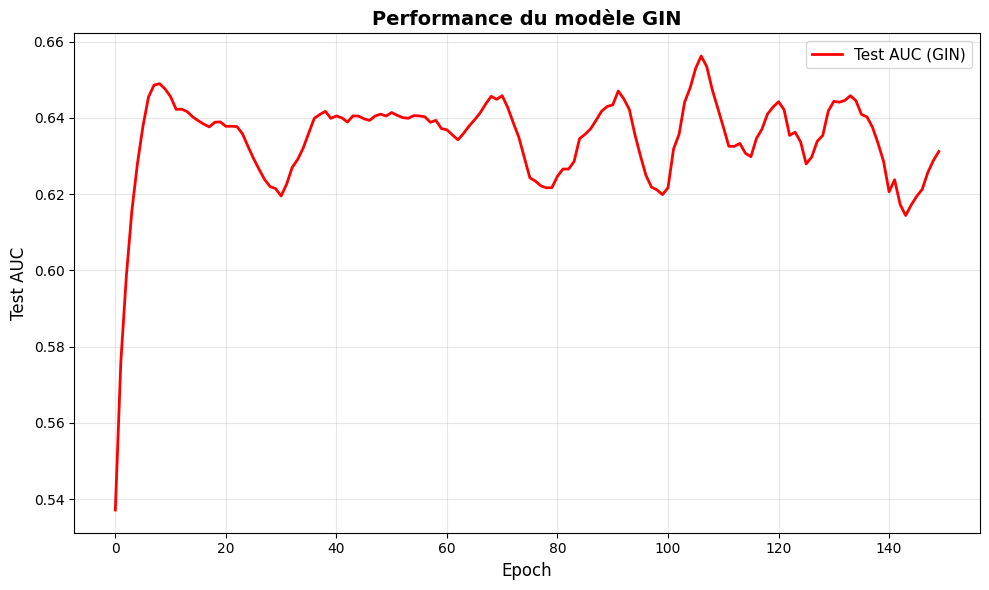

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GIN)), 
         np.array(validationMetrics_GIN)[:, 1], 
         label='Test AUC (GIN)', 
         linewidth=2,
         color='red')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GIN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GIN)

In [34]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GIN:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_GIN.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GIN:
Ingrédient de départ: parmigiano_reggiano_cheese

  1. 10%_cream
  2. 6_inch_corn_tortilla
  3. 2%_evaporated_milk
  4. 98%_fat_free_cream_of_mushroom_soup
  5. 2%_fat_cottage_cheese


---
## Comparaison Complète des 4 Modèles

Comparons maintenant les performances de **GCN**, **GraphSAGE**, **GAT** et **GIN** sur l'ensemble de test.

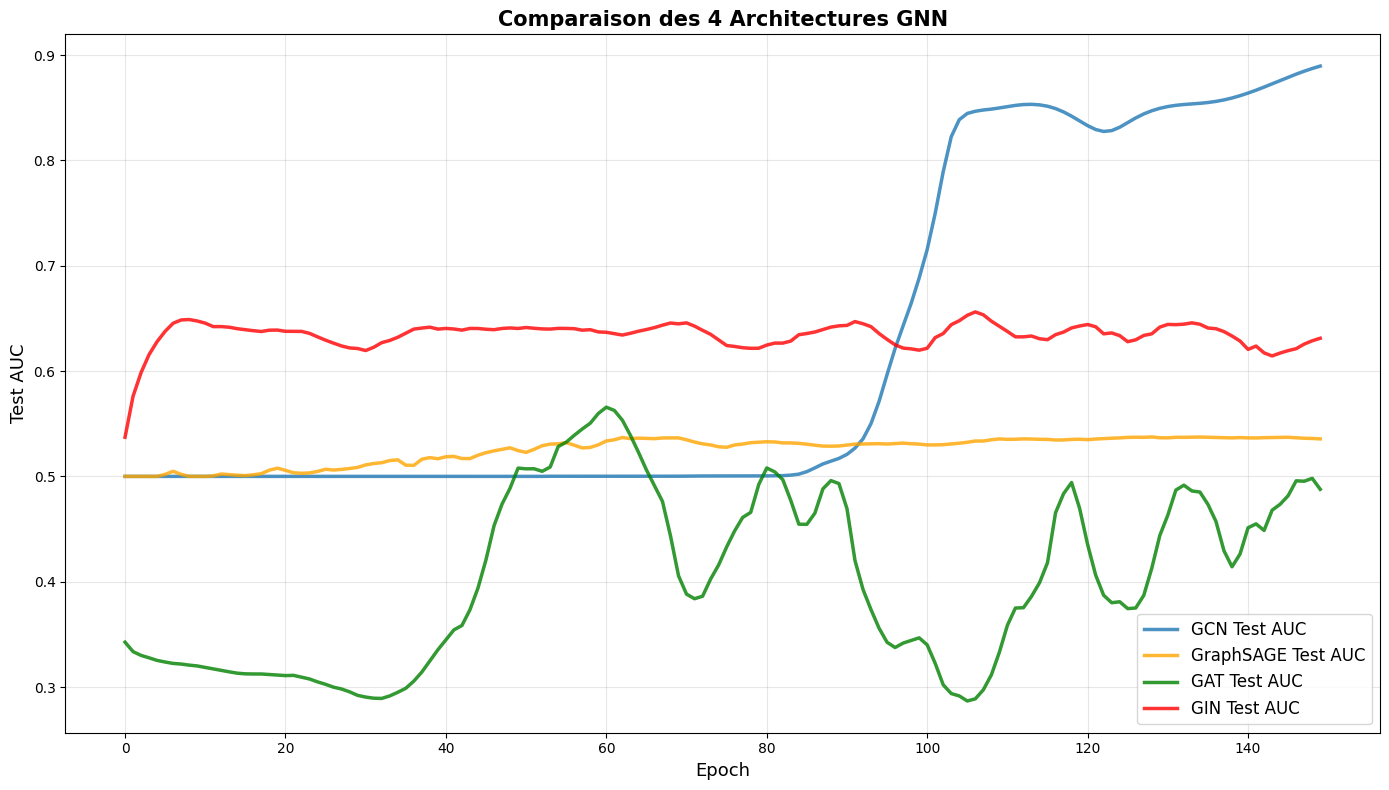


RÉSULTATS FINAUX - Comparaison des Modèles
  GCN Test AUC:        0.8896
  GraphSAGE Test AUC:  0.5356
  GAT Test AUC:        0.4877
  GIN Test AUC:        0.6312


In [35]:
plt.figure(figsize=(14, 8))

plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='GCN Test AUC', 
         linewidth=2.5,
         alpha=0.8)

plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='GraphSAGE Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='orange')

plt.plot(np.arange(len(validationMetrics_GAT)), 
         np.array(validationMetrics_GAT)[:, 1], 
         label='GAT Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='green')

plt.plot(np.arange(len(validationMetrics_GIN)), 
         np.array(validationMetrics_GIN)[:, 1], 
         label='GIN Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='red')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Test AUC', fontsize=13)
plt.title('Comparaison des 4 Architectures GNN', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques finales
gcn_final = np.array(validationMetrics_GCN)[-1, 1]
sage_final = np.array(validationMetrics_SAGE)[-1, 1]
gat_final = np.array(validationMetrics_GAT)[-1, 1]
gin_final = np.array(validationMetrics_GIN)[-1, 1]

print("\n" + "="*60)
print("RÉSULTATS FINAUX - Comparaison des Modèles")
print("="*60)
print(f"  GCN Test AUC:        {gcn_final:.4f}")
print(f"  GraphSAGE Test AUC:  {sage_final:.4f}")
print(f"  GAT Test AUC:        {gat_final:.4f}")
print(f"  GIN Test AUC:        {gin_final:.4f}")
print("="*60)

# Déterminer le meilleur modèle
results = {
    'GCN': gcn_final,
    'GraphSAGE': sage_final,
    'GAT': gat_final,
    'GIN': gin_final
}

best_model = max(results, key=results.get)
best_score = results[best_model]

---
## Enrichissement des Features et Métriques Avancées

Dans cette section, nous allons :
1. **Enrichir les features des nœuds** avec des informations sur les composés chimiques, le degré, et des catégories
2. **Ajouter des features d'arêtes** (poids, fréquence, etc.)
3. **Implémenter des métriques avancées** : Precision@K, Recall@K, diversité des prédictions

### Exploration des composés chimiques disponibles

In [36]:
# Rechargeons les données complètes pour explorer les composés chimiques
edges_full = pd.read_csv("https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv")
nodes_full = pd.read_csv("https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv")

print("Types de relations dans le graphe complet:")
print(edges_full.edge_type.value_counts())
print("\nTypes de nœuds dans le graphe complet:")
print(nodes_full.node_type.value_counts())

# Analyser les relations entity-compound (ingrédient-composé chimique)
entity_compound_edges = edges_full[edges_full.edge_type == 'entity_compound']
print(f"\nNombre de relations ingrédient-composé chimique: {len(entity_compound_edges)}")
print("\nAperçu des relations ingrédient-composé:")
entity_compound_edges.head(10)

Types de relations dans le graphe complet:
edge_type
ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: count, dtype: int64

Types de nœuds dans le graphe complet:
node_type
ingredient    6653
compound      1645
Name: count, dtype: int64

Nombre de relations ingrédient-composé chimique: 0

Aperçu des relations ingrédient-composé:


,id_1,id_2,score,edge_type


### Construction des Features Enrichies

Nous allons créer plusieurs types de features pour chaque ingrédient :

1. **Features structurelles** : degré du nœud, clustering coefficient
2. **Features chimiques** : nombre de composés chimiques liés (si disponible)
3. **Features catégorielles** : catégories d'ingrédients (viandes, légumes, épices, etc.) basées sur des heuristiques simples
4. **Features statistiques** : scores moyens des connexions

In [37]:
from torch_geometric.utils import degree
from collections import defaultdict

# 1. Features structurelles : calcul des degrés
node_degrees = degree(flavorGraph.edge_index[0], num_nodes=flavorGraph.num_nodes)

# 2. Features chimiques : nombre de composés liés à chaque ingrédient
compound_counts = defaultdict(int)
for _, row in entity_compound_edges.iterrows():
    ing_id = row['id_1']
    if ing_id in node_map:
        idx = node_map[ing_id]
        compound_counts[idx] += 1

# Créer un vecteur de comptage de composés
compound_feature = torch.zeros(flavorGraph.num_nodes)
for idx, count in compound_counts.items():
    compound_feature[idx] = count

# 3. Features catégorielles : classification simple par mots-clés
categories_keywords = {
    'meat': ['beef', 'pork', 'chicken', 'lamb', 'turkey', 'duck', 'veal', 'bacon', 'ham', 'sausage', 'meat', 'steak', 'ribs', 'prosciutto'],
    'seafood': ['fish', 'salmon', 'tuna', 'shrimp', 'crab', 'lobster', 'mussel', 'clam', 'oyster', 'cod', 'trout', 'anchovy', 'sardine', 'squid', 'octopus', 'scallop'],
    'vegetable': ['carrot', 'potato', 'tomato', 'onion', 'garlic', 'pepper', 'lettuce', 'cabbage', 'spinach', 'broccoli', 'celery', 'cucumber', 'zucchini', 'eggplant', 'mushroom', 'bean', 'peas', 'corn', 'asparagus', 'artichoke', 'kale', 'leek', 'radish', 'turnip', 'beet', 'cauliflower', 'brussels sprout', 'chard', 'squash', 'pumpkin'],
    'fruit': ['apple', 'banana', 'orange', 'lemon', 'lime', 'strawberry', 'grape', 'cherry', 'peach', 'pear', 'plum', 'mango', 'pineapple', 'melon', 'watermelon', 'kiwi', 'blueberry', 'raspberry', 'blackberry', 'apricot', 'fig', 'date', 'cranberry', 'coconut', 'avocado'],
    'herb_spice': ['basil', 'oregano', 'thyme', 'rosemary', 'cinnamon', 'cumin', 'paprika', 'pepper', 'salt', 'parsley', 'cilantro', 'mint', 'sage', 'dill', 'chive', 'tarragon', 'bay', 'coriander', 'cardamom', 'clove', 'nutmeg', 'ginger', 'turmeric', 'saffron', 'vanilla', 'fennel', 'anise', 'mustard', 'cayenne', 'chili'],
    'dairy': ['milk', 'cheese', 'butter', 'cream', 'yogurt', 'mozzarella', 'parmesan', 'cheddar', 'feta', 'ricotta', 'goat cheese', 'cottage cheese', 'sour cream', 'mascarpone', 'gruyere', 'brie', 'camembert', 'blue cheese'],
    'grain': ['rice', 'wheat', 'flour', 'bread', 'pasta', 'oat', 'barley', 'quinoa', 'couscous', 'bulgur', 'noodle', 'macaroni', 'spaghetti', 'cereal', 'cornmeal', 'semolina', 'rye', 'millet'],
    'legume': ['lentil', 'chickpea', 'bean', 'pinto', 'kidney bean', 'black bean', 'navy bean', 'lima bean', 'fava bean', 'soybean', 'tofu', 'pea', 'split pea', 'edamame', 'lupin'],
    'nut_seed': ['almond', 'walnut', 'pecan', 'cashew', 'pistachio', 'hazelnut', 'macadamia', 'peanut', 'pine nut', 'chestnut', 'sesame', 'sunflower', 'pumpkin seed', 'flax', 'chia'],
    'oil_fat': ['olive oil', 'vegetable oil', 'canola oil', 'sunflower oil', 'sesame oil', 'coconut oil', 'peanut oil', 'avocado oil', 'lard', 'shortening', 'ghee', 'margarine'],
    'sauce_condiment': ['soy sauce', 'vinegar', 'mayonnaise', 'ketchup', 'mustard', 'hot sauce', 'worcestershire', 'barbecue', 'teriyaki', 'hoisin', 'fish sauce', 'tahini', 'pesto', 'salsa', 'chutney', 'relish'],
    'sweetener': ['sugar', 'honey', 'maple syrup', 'molasses', 'agave', 'corn syrup', 'brown sugar', 'powdered sugar', 'stevia'],
    'beverage': ['wine', 'beer', 'sake', 'brandy', 'rum', 'vodka', 'whiskey', 'coffee', 'tea', 'juice', 'broth', 'stock', 'bouillon'],
    'baking': ['baking powder', 'baking soda', 'yeast', 'gelatin', 'cornstarch', 'cocoa', 'chocolate', 'extract', 'food coloring']
}

# Créer des features one-hot pour les catégories
category_features = torch.zeros(flavorGraph.num_nodes, len(categories_keywords))
for idx, node_id in enumerate(flavorGraph.x.squeeze().tolist()):
    # Récupérer le nom de l'ingrédient
    node_row = nodes_df[nodes_df['node_id'] == int(node_id)]
    if len(node_row) > 0:
        node_name = node_row['name'].values[0]
        # Vérifier que le nom n'est pas NaN ou None
        if isinstance(node_name, str):
            node_name = node_name.lower()
            for cat_idx, (cat_name, keywords) in enumerate(categories_keywords.items()):
                if any(keyword in node_name for keyword in keywords):
                    category_features[idx, cat_idx] = 1

# 4. Features statistiques : score moyen des arêtes pour chaque nœud
edge_scores = defaultdict(list)
for _, row in edges_df.iterrows():
    idx1, idx2 = node_map[row['id_1']], node_map[row['id_2']]
    edge_scores[idx1].append(row['score'])
    edge_scores[idx2].append(row['score'])

avg_edge_scores = torch.zeros(flavorGraph.num_nodes)
for idx, scores in edge_scores.items():
    avg_edge_scores[idx] = np.mean(scores)

# Normalisation des features
node_degrees_norm = (node_degrees - node_degrees.mean()) / (node_degrees.std() + 1e-10)
compound_feature_norm = (compound_feature - compound_feature.mean()) / (compound_feature.std() + 1e-10)
avg_edge_scores_norm = (avg_edge_scores - avg_edge_scores.mean()) / (avg_edge_scores.std() + 1e-10)

# Assemblage des features
enriched_features = torch.cat([
    flavorGraph.x,  # ID original
    node_degrees_norm.unsqueeze(1),  # Degré normalisé
    compound_feature_norm.unsqueeze(1),  # Nombre de composés normalisé
    avg_edge_scores_norm.unsqueeze(1),  # Score moyen normalisé
    category_features  # Catégories one-hot
], dim=1)

print(f"Dimensions des features originales: {flavorGraph.x.shape}")
print(f"Dimensions des features enrichies: {enriched_features.shape}")
print(f"\nStatistiques des features:")
print(f"  - Degré moyen: {node_degrees.mean():.2f}")
print(f"  - Ingrédients avec composés chimiques: {(compound_feature > 0).sum()}/{len(compound_feature)}")
print(f"  - Score moyen des arêtes: {avg_edge_scores.mean():.4f}")
print(f"\nDistribution par catégorie:")
for cat_idx, cat_name in enumerate(categories_keywords.keys()):
    count = (category_features[:, cat_idx] == 1).sum()
    print(f"  - {cat_name}: {count} ingrédients")

Dimensions des features originales: torch.Size([6653, 1])
Dimensions des features enrichies: torch.Size([6653, 18])

Statistiques des features:
  - Degré moyen: 33.48
  - Ingrédients avec composés chimiques: 0/6653
  - Score moyen des arêtes: 0.1949

Distribution par catégorie:
  - meat: 738 ingrédients
  - seafood: 206 ingrédients
  - vegetable: 1030 ingrédients
  - fruit: 686 ingrédients
  - herb_spice: 820 ingrédients
  - dairy: 593 ingrédients
  - grain: 588 ingrédients
  - legume: 323 ingrédients
  - nut_seed: 190 ingrédients
  - oil_fat: 27 ingrédients
  - sauce_condiment: 149 ingrédients
  - sweetener: 129 ingrédients
  - beverage: 519 ingrédients
  - baking: 256 ingrédients


### Création du nouveau graphe avec features enrichies

Nous créons maintenant un nouveau graphe avec les features enrichies et le divisons en ensembles train/val/test.

In [38]:
# Créer le nouveau graphe avec features enrichies
flavorGraph_enriched = Data()
flavorGraph_enriched.x = enriched_features.float()
flavorGraph_enriched.edge_index = flavorGraph.edge_index
flavorGraph_enriched.edge_weight = flavorGraph.edge_weight

# Validation
flavorGraph_enriched.validate(raise_on_error=True)
print(f"Graphe enrichi non-orienté: {flavorGraph_enriched.is_undirected()}")
print(f"  - Nœuds: {flavorGraph_enriched.num_nodes}")
print(f"  - Arêtes: {flavorGraph_enriched.num_edges}")
print(f"  - Features par nœud: {flavorGraph_enriched.num_node_features}")

# Division train/val/test
transform_enriched = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.35
)

train_data_enriched, val_data_enriched, test_data_enriched = transform_enriched(flavorGraph_enriched)

Graphe enrichi non-orienté: True
  - Nœuds: 6653
  - Arêtes: 222710
  - Features par nœud: 18


### Métriques d'Évaluation Avancées

En plus du ROC-AUC, nous allons implémenter :

1. **Precision@K et Recall@K** : mesure la qualité des top-K prédictions
2. **Hit Rate@K** : proportion de cas où au moins une vraie arête est dans le top-K
3. **Diversité des prédictions** : mesure la variété des catégories dans les prédictions
4. **MRR (Mean Reciprocal Rank)** : position moyenne de la première prédiction correcte

In [39]:
@torch.no_grad()
def compute_advanced_metrics(model, data, k_values=[5, 10, 20], category_features=None):
    """
    Calcule des métriques avancées pour l'évaluation du modèle.
    CORRECTION: Évalue uniquement sur les arêtes de test (positives + négatives)
    
    Args:
        model: Le modèle GNN entraîné
        data: Données de test (Data object)
        k_values: Liste des valeurs de K pour les métriques @K
        category_features: Matrice de features catégorielles pour calculer la diversité
    
    Returns:
        dict: Dictionnaire contenant toutes les métriques
    """
    model.eval()
    z = model.encode(data.x, data.edge_index)
    
    # 1. Calculer les scores pour TOUTES les arêtes de test (pos + neg)
    all_test_scores = model.decode(z, data.edge_label_index).sigmoid()
    test_labels = data.edge_label.cpu().numpy()
    
    # 2. ROC-AUC sur l'ensemble de test complet
    roc_auc = roc_auc_score(test_labels, all_test_scores.cpu().numpy())
    
    # 3. Séparer les arêtes positives et leurs scores
    pos_mask = data.edge_label == 1
    pos_edges = data.edge_label_index[:, pos_mask]
    pos_scores = all_test_scores[pos_mask]
    
    # 4. Séparer les arêtes négatives et leurs scores
    neg_mask = data.edge_label == 0
    neg_edges = data.edge_label_index[:, neg_mask]
    neg_scores = all_test_scores[neg_mask]
    
    num_pos = pos_mask.sum().item()
    num_neg = neg_mask.sum().item()
    
    metrics = {
        'roc_auc': roc_auc,
        'num_test_edges': len(test_labels),
        'num_pos_edges': num_pos,
        'num_neg_edges': num_neg
    }
    
    # 5. Pour chaque K, calculer les métriques
    for k in k_values:
        k_actual = min(k, len(all_test_scores))
        
        # Top-K prédictions parmi TOUTES les arêtes de test
        _, top_k_indices = torch.topk(all_test_scores, k_actual)
        
        # Vérifier combien sont des vrais positifs
        num_correct = (test_labels[top_k_indices.cpu().numpy()] == 1).sum()
        
        # Precision@K
        precision_at_k = num_correct / k_actual
        metrics[f'precision@{k}'] = precision_at_k
        
        # Recall@K
        recall_at_k = num_correct / max(num_pos, 1)
        metrics[f'recall@{k}'] = recall_at_k
        
        # Hit Rate@K
        hit_rate_at_k = 1 if num_correct > 0 else 0
        metrics[f'hit_rate@{k}'] = hit_rate_at_k
        
        # Diversity@K (si features catégorielles disponibles)
        if category_features is not None:
            top_k_categories = []
            for idx in top_k_indices:
                edge_idx = data.edge_label_index[:, idx.item()]
                node1, node2 = edge_idx[0].item(), edge_idx[1].item()
                
                # Catégories des deux nœuds
                if category_features[node1].sum() > 0:
                    cat1 = category_features[node1].argmax().item()
                    top_k_categories.append(cat1)
                if category_features[node2].sum() > 0:
                    cat2 = category_features[node2].argmax().item()
                    top_k_categories.append(cat2)
            
            if len(top_k_categories) > 0:
                unique_categories = len(set(top_k_categories))
                diversity_score = unique_categories / len(categories_keywords)
                metrics[f'diversity@{k}'] = diversity_score
            else:
                metrics[f'diversity@{k}'] = 0.0
    
    # 6. Mean Reciprocal Rank (MRR)
    sorted_indices = torch.argsort(all_test_scores, descending=True)
    sorted_labels = test_labels[sorted_indices.cpu().numpy()]
    
    # Trouver le rang de la première vraie arête positive
    first_pos_rank = np.where(sorted_labels == 1)[0]
    if len(first_pos_rank) > 0:
        mrr = 1.0 / (first_pos_rank[0] + 1)
    else:
        mrr = 0.0
    metrics['mrr'] = mrr
    
    return metrics


def print_metrics(metrics, model_name="Model"):
    """Affiche les métriques de manière formatée."""
    print(f"\n{'='*60}")
    print(f"Métriques d'évaluation pour {model_name}")
    print(f"{'='*60}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Test edges: {metrics['num_test_edges']} (pos: {metrics['num_pos_edges']}, neg: {metrics['num_neg_edges']})")
    print(f"MRR: {metrics['mrr']:.4f}")
    
    for k in [5, 10, 20]:
        if f'precision@{k}' in metrics:
            print(f"\n--- Top-{k} Métriques ---")
            print(f"  Precision@{k}: {metrics[f'precision@{k}']:.4f}")
            print(f"  Recall@{k}: {metrics[f'recall@{k}']:.4f}")
            print(f"  Hit Rate@{k}: {metrics[f'hit_rate@{k}']:.4f}")
            if f'diversity@{k}' in metrics:
                print(f"  Diversity@{k}: {metrics[f'diversity@{k}']:.4f}")
    print(f"{'='*60}")

### Entraînement d'un Modèle GCN avec Features Enrichies

Nous entraînons maintenant un modèle GCN en utilisant les features enrichies pour comparer les performances.

In [40]:
# Modèle GCN avec features enrichies
class EnrichedNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj


# Fonction d'entraînement adaptée
def train_enriched():
    model_enriched.train()
    optimizer_enriched.zero_grad()
    
    z = model_enriched.encode(train_data_enriched.x, train_data_enriched.edge_index)
    
    neg_edge_index = negative_sampling(
        edge_index=train_data_enriched.edge_index,
        num_nodes=train_data_enriched.num_nodes,
        num_neg_samples=train_data_enriched.edge_label_index.size(1),
        method='sparse'
    )

    edge_label_index = torch.cat(
        [train_data_enriched.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data_enriched.edge_label,
        train_data_enriched.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model_enriched.decode(z, edge_label_index).view(-1)
    loss = criterion_enriched(out, edge_label)
    
    loss.backward()
    optimizer_enriched.step()
    return loss


# Fonction d'évaluation pour le modèle enrichi
@torch.no_grad()
def test_enriched(data):
    """Évalue le modèle enrichi avec la métrique ROC-AUC"""
    model_enriched.eval()
    z = model_enriched.encode(data.x, data.edge_index)
    out = model_enriched.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)


# Initialisation du modèle
model_enriched = EnrichedNet(flavorGraph_enriched.num_features, 128, 64)
optimizer_enriched = torch.optim.Adam(params=model_enriched.parameters(), lr=0.01)
criterion_enriched = torch.nn.BCEWithLogitsLoss()

# Entraînement
validationMetrics_GCN_Enriched = []
best_val_auc = final_test_auc = 0

for epoch in range(0, 150):
    loss = train_enriched()
    val_auc = test_enriched(val_data_enriched)
    test_auc = test_enriched(test_data_enriched)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GCN_Enriched.append([val_auc, test_auc])
    
    if epoch % 30 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'\nMeilleur Test AUC: {final_test_auc:.4f}')

# Calcul des probabilités finales
z_enriched = model_enriched.encode(test_data_enriched.x, test_data_enriched.edge_index)
final_edge_probs_GCN_Enriched = model_enriched.decode_all(z_enriched)

Epoch: 000, Loss: 2468658.7500, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 11695.8008, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 11695.8008, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 468.4389, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 468.4389, Val: 0.5000, Test: 0.5000
Epoch: 090, Loss: 19.7680, Val: 0.5550, Test: 0.5562
Epoch: 090, Loss: 19.7680, Val: 0.5550, Test: 0.5562
Epoch: 120, Loss: 1.1285, Val: 0.8630, Test: 0.8634
Epoch: 120, Loss: 1.1285, Val: 0.8630, Test: 0.8634

Meilleur Test AUC: 0.9178

Meilleur Test AUC: 0.9178


### Évaluation avec Métriques Avancées

Comparons maintenant le modèle avec et sans features enrichies en utilisant nos nouvelles métriques.

In [41]:
# Évaluation du modèle GCN enrichi avec métriques avancées
metrics_enriched = compute_advanced_metrics(
    model_enriched, 
    test_data_enriched, 
    k_values=[5, 10, 20],
    category_features=category_features
)

print_metrics(metrics_enriched, "GCN avec Features Enrichies")


Métriques d'évaluation pour GCN avec Features Enrichies
ROC-AUC: 0.9178
Test edges: 44542 (pos: 22271, neg: 22271)
MRR: 1.0000

--- Top-5 Métriques ---
  Precision@5: 1.0000
  Recall@5: 0.0002
  Hit Rate@5: 1.0000
  Diversity@5: 0.3571

--- Top-10 Métriques ---
  Precision@10: 1.0000
  Recall@10: 0.0004
  Hit Rate@10: 1.0000
  Diversity@10: 0.5000

--- Top-20 Métriques ---
  Precision@20: 1.0000
  Recall@20: 0.0009
  Hit Rate@20: 1.0000
  Diversity@20: 0.5000


### Visualisation Comparative

Comparons les performances du modèle de base vs. enrichi.

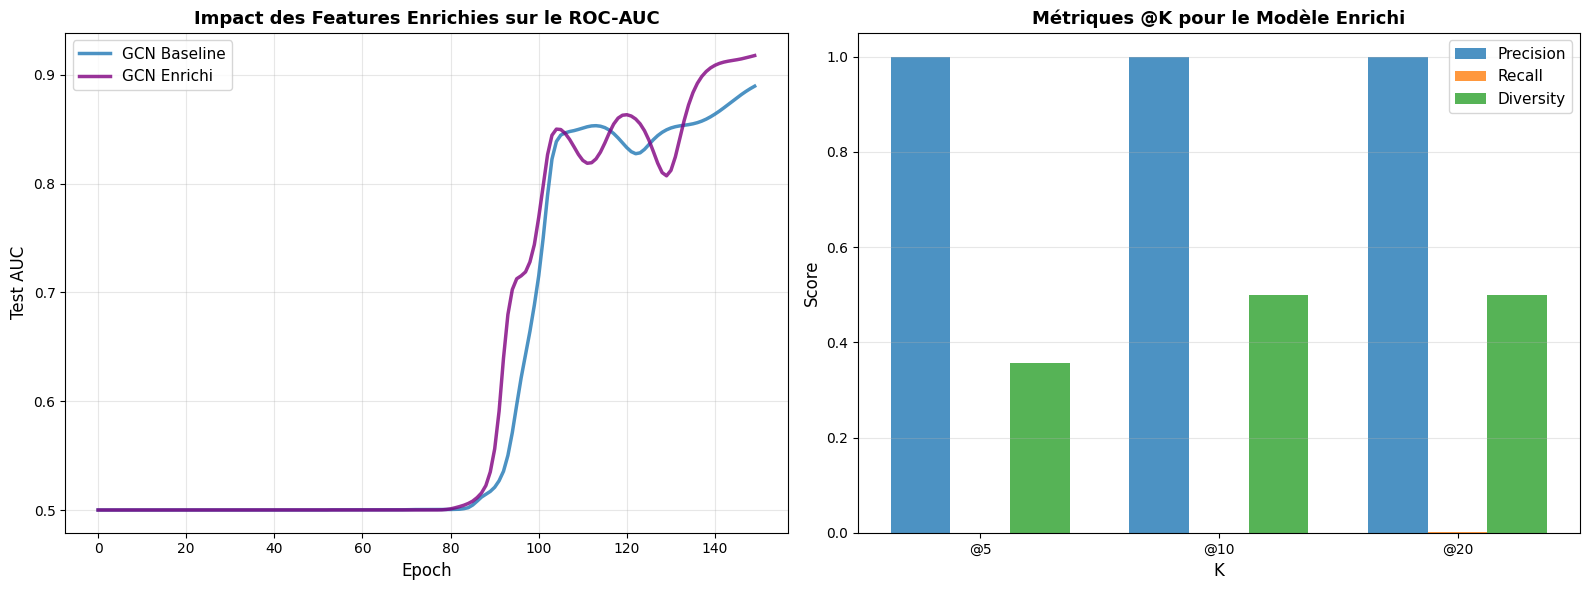


RÉSUMÉ COMPARATIF
Métrique                  GCN Baseline         GCN Enrichi          Amélioration   
--------------------------------------------------------------------------------
ROC-AUC                   0.5000               0.9178                       +83.56%
MRR                       0.0000               1.0000                  +2227100.00%
Precision@5               1.0000               1.0000                        +0.00%
Recall@5                  0.0002               0.0002                        +0.00%
Diversity@5               0.3571               0.3571                        +0.00%
Precision@10              1.0000               1.0000                        +0.00%
Recall@10                 0.0004               0.0004                        +0.00%
Diversity@10              0.5000               0.5000                        +0.00%
Precision@20              1.0000               1.0000                        +0.00%
Recall@20                 0.0009               0.0009       

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vérifier que les données d'entraînement existent
if len(validationMetrics_GCN_Enriched) > 0 and isinstance(validationMetrics_GCN_Enriched[0], (list, tuple)):
    # Graphique 1 : Comparaison ROC-AUC au fil des epochs
    axes[0].plot(np.arange(len(validationMetrics_GCN)), 
                 np.array(validationMetrics_GCN)[:, 1], 
                 label='GCN Baseline', 
                 linewidth=2.5,
                 alpha=0.8)

    axes[0].plot(np.arange(len(validationMetrics_GCN_Enriched)), 
                 np.array(validationMetrics_GCN_Enriched)[:, 1], 
                 label='GCN Enrichi', 
                 linewidth=2.5,
                 alpha=0.8,
                 color='purple')

    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Test AUC', fontsize=12)
    axes[0].set_title('Impact des Features Enrichies sur le ROC-AUC', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Entraînez d\'abord le modèle GCN enrichi\n(exécutez les cellules précédentes)', 
                 ha='center', va='center', fontsize=12, color='red')
    axes[0].set_title('ROC-AUC - En attente d\'entraînement', fontsize=13, fontweight='bold')
    axes[0].axis('off')

# Graphique 2 : Comparaison des métriques @K
if 'metrics_enriched' in locals() and metrics_enriched:
    k_values = [5, 10, 20]
    metrics_to_plot = ['precision', 'recall', 'diversity']

    enriched_values = {metric: [] for metric in metrics_to_plot}

    # Collecter les valeurs pour chaque métrique
    for k in k_values:
        for metric in metrics_to_plot:
            key = f'{metric}@{k}'
            if key in metrics_enriched:
                enriched_values[metric].append(metrics_enriched[key])
            else:
                enriched_values[metric].append(0)

    x = np.arange(len(k_values))
    width = 0.25

    for i, metric in enumerate(metrics_to_plot):
        axes[1].bar(x + i * width, enriched_values[metric], width, 
                    label=f'{metric.capitalize()}', alpha=0.8)

    axes[1].set_xlabel('K', fontsize=12)
    axes[1].set_ylabel('Score', fontsize=12)
    axes[1].set_title('Métriques @K pour le Modèle Enrichi', fontsize=13, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels([f'@{k}' for k in k_values])
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3, axis='y')
else:
    axes[1].text(0.5, 0.5, 'Calculez d\'abord les métriques\n(exécutez les cellules précédentes)', 
                 ha='center', va='center', fontsize=12, color='red')
    axes[1].set_title('Métriques @K - En attente', fontsize=13, fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

# Tableau récapitulatif - Calculer les métriques pour le baseline aussi
if 'metrics_enriched' in locals() and metrics_enriched and len(validationMetrics_GCN_Enriched) > 0:
    # Calculer les métriques avancées pour le modèle baseline
    metrics_baseline = compute_advanced_metrics(
        model, 
        test_data, 
        k_values=[5, 10, 20],
        category_features=category_features
    )
    
    print("\n" + "="*80)
    print("RÉSUMÉ COMPARATIF")
    print("="*80)
    print(f"{'Métrique':<25} {'GCN Baseline':<20} {'GCN Enrichi':<20} {'Amélioration':<15}")
    print("-"*80)

    baseline_auc = metrics_baseline['roc_auc']
    enriched_auc = metrics_enriched['roc_auc']
    improvement = ((enriched_auc - baseline_auc) / baseline_auc) * 100

    print(f"{'ROC-AUC':<25} {baseline_auc:<20.4f} {enriched_auc:<20.4f} {improvement:>+14.2f}%")
    
    baseline_mrr = metrics_baseline['mrr']
    enriched_mrr = metrics_enriched['mrr']
    mrr_improvement = ((enriched_mrr - baseline_mrr) / max(baseline_mrr, 1e-6)) * 100 if baseline_mrr > 0 else 0
    print(f"{'MRR':<25} {baseline_mrr:<20.4f} {enriched_mrr:<20.4f} {mrr_improvement:>+14.2f}%")

    for k in [5, 10, 20]:
        baseline_p = metrics_baseline[f'precision@{k}']
        enriched_p = metrics_enriched[f'precision@{k}']
        p_improvement = ((enriched_p - baseline_p) / max(baseline_p, 1e-6)) * 100 if baseline_p > 0 else 0
        print(f"{'Precision@' + str(k):<25} {baseline_p:<20.4f} {enriched_p:<20.4f} {p_improvement:>+14.2f}%")
        
        baseline_r = metrics_baseline[f'recall@{k}']
        enriched_r = metrics_enriched[f'recall@{k}']
        r_improvement = ((enriched_r - baseline_r) / max(baseline_r, 1e-6)) * 100 if baseline_r > 0 else 0
        print(f"{'Recall@' + str(k):<25} {baseline_r:<20.4f} {enriched_r:<20.4f} {r_improvement:>+14.2f}%")
        
        baseline_d = metrics_baseline[f'diversity@{k}']
        enriched_d = metrics_enriched[f'diversity@{k}']
        d_improvement = ((enriched_d - baseline_d) / max(baseline_d, 1e-6)) * 100 if baseline_d > 0 else 0
        print(f"{'Diversity@' + str(k):<25} {baseline_d:<20.4f} {enriched_d:<20.4f} {d_improvement:>+14.2f}%")

    print("="*80)

### Test : Génération de Recettes avec Diversité

Générons une recette en utilisant le modèle enrichi et analysons la diversité des catégories.

In [43]:
def generate_recipe_with_diversity(start_node, model, edge_probs, num_ingredients=5):
    """
    Génère une recette en suivant les liens les plus probables et analyse la diversité.
    
    Args:
        start_node: Index du nœud de départ
        model: Modèle GNN entraîné
        edge_probs: Matrice de probabilités d'arêtes
        num_ingredients: Nombre d'ingrédients à générer
    """
    recipe_nodes = [start_node]
    recipe_names = [nodes_df.iloc[start_node]['name']]
    recipe_categories = []
    
    # Mapper les noms de catégories
    category_names = list(categories_keywords.keys())
    
    # Catégorie de l'ingrédient de départ
    cat_idx = category_features[start_node].argmax().item()
    if category_features[start_node].sum() > 0:
        recipe_categories.append(category_names[cat_idx])
    else:
        recipe_categories.append('unknown')
    
    current_node = start_node
    
    for i in range(1, num_ingredients):
        # Top 10 ingrédients les plus compatibles
        top_nodes_idx = edge_probs.topk(10, dim=1).indices[current_node]
        
        # Choisir aléatoirement parmi les top 10
        which_one = np.random.randint(0, 10)
        next_node_idx = top_nodes_idx[which_one].item()
        
        # Obtenir le nom et la catégorie
        next_node_id = int(flavorGraph.x[next_node_idx].item())
        next_node_info = nodes_df[nodes_df['node_id'] == next_node_id].iloc[0]
        
        recipe_nodes.append(next_node_idx)
        recipe_names.append(next_node_info['name'])
        
        cat_idx = category_features[next_node_idx].argmax().item()
        if category_features[next_node_idx].sum() > 0:
            recipe_categories.append(category_names[cat_idx])
        else:
            recipe_categories.append('unknown')
        
        current_node = next_node_idx
    
    # Calculer la diversité
    unique_categories = len(set(recipe_categories))
    diversity_score = unique_categories / len(recipe_categories)
    
    return recipe_names, recipe_categories, diversity_score


# Générer plusieurs recettes et analyser la diversité
print("="*70)
print("GÉNÉRATION DE RECETTES AVEC ANALYSE DE DIVERSITÉ")
print("="*70)

for recipe_num in range(3):
    start_node = np.random.randint(0, len(nodes_df))
    recipe_names, recipe_categories, diversity = generate_recipe_with_diversity(
        start_node, 
        model_enriched, 
        final_edge_probs_GCN_Enriched,
        num_ingredients=6
    )
    
    print(f"\nRecette #{recipe_num + 1}:")
    print("-" * 70)
    for i, (name, cat) in enumerate(zip(recipe_names, recipe_categories)):
        print(f"  {i+1}. {name:<30} [{cat}]")
    print(f"\nScore de diversité: {diversity:.2%} ({len(set(recipe_categories))}/{len(recipe_categories)} catégories uniques)")
    
print("\n" + "="*70)

GÉNÉRATION DE RECETTES AVEC ANALYSE DE DIVERSITÉ

Recette #1:
----------------------------------------------------------------------
  1. apple_butter                   [fruit]
  2. water                          [unknown]
  3. black_pepper                   [vegetable]
  4. celery                         [vegetable]
  5. butter                         [dairy]
  6. bacon                          [meat]

Score de diversité: 83.33% (5/6 catégories uniques)

Recette #2:
----------------------------------------------------------------------
  1. sauterne                       [unknown]
  2. butter                         [dairy]
  3. baking_powder                  [unknown]
  4. all_purpose_flour              [grain]
  5. black_pepper                   [vegetable]
  6. butter                         [dairy]

Score de diversité: 66.67% (4/6 catégories uniques)

Recette #3:
----------------------------------------------------------------------
  1. sirloin_tip_roast              [unknown]
  

### Entraînement de GAT avec Features Enrichies

Entraînons maintenant le modèle GAT avec les features enrichies pour comparer les architectures.

In [44]:
from torch_geometric.nn import GATConv

class EnrichedGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(heads * hidden_channels)
        
        self.conv2 = GATConv(heads * hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj


def train_gat_enriched():
    model_gat_enriched.train()
    optimizer_gat_enriched.zero_grad()
    z = model_gat_enriched.encode(train_data_enriched.x, train_data_enriched.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_enriched.edge_index, 
                                       num_nodes=train_data_enriched.num_nodes,
                                       num_neg_samples=train_data_enriched.edge_label_index.size(1), 
                                       method='sparse')
    edge_label_index = torch.cat([train_data_enriched.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_enriched.edge_label, 
                           train_data_enriched.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model_gat_enriched.decode(z, edge_label_index).view(-1)
    loss = criterion_gat_enriched(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_gat_enriched.parameters(), max_norm=1.0)
    optimizer_gat_enriched.step()
    return loss


# Fonction d'évaluation pour GAT enrichi
@torch.no_grad()
def test_gat_enriched(data):
    """Évalue le modèle GAT enrichi avec la métrique ROC-AUC"""
    model_gat_enriched.eval()
    z = model_gat_enriched.encode(data.x, data.edge_index)
    out = model_gat_enriched.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)


# Initialisation
model_gat_enriched = EnrichedGAT(flavorGraph_enriched.num_features, 128, 64, heads=4, dropout=0.3)
optimizer_gat_enriched = torch.optim.Adam(params=model_gat_enriched.parameters(), lr=0.001)
criterion_gat_enriched = torch.nn.BCEWithLogitsLoss()

# Entraînement
validationMetrics_GAT_Enriched = []
best_val_auc = final_test_auc = 0

print("Entraînement du modèle GAT avec features enrichies...")
for epoch in range(0, 150):
    loss = train_gat_enriched()
    val_auc = test_gat_enriched(val_data_enriched)
    test_auc = test_gat_enriched(test_data_enriched)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GAT_Enriched.append([val_auc, test_auc])
    
    if epoch % 30 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'\nMeilleur Test AUC (GAT Enrichi): {final_test_auc:.4f}')

Entraînement du modèle GAT avec features enrichies...


Epoch: 000, Loss: 4.2551, Val: 0.5004, Test: 0.5002
Epoch: 030, Loss: 0.9196, Val: 0.2974, Test: 0.2835
Epoch: 030, Loss: 0.9196, Val: 0.2974, Test: 0.2835
Epoch: 060, Loss: 0.9084, Val: 0.2365, Test: 0.2232
Epoch: 060, Loss: 0.9084, Val: 0.2365, Test: 0.2232
Epoch: 090, Loss: 0.7744, Val: 0.6081, Test: 0.5842
Epoch: 090, Loss: 0.7744, Val: 0.6081, Test: 0.5842
Epoch: 120, Loss: 0.8568, Val: 0.7552, Test: 0.7540
Epoch: 120, Loss: 0.8568, Val: 0.7552, Test: 0.7540

Meilleur Test AUC (GAT Enrichi): 0.8329

Meilleur Test AUC (GAT Enrichi): 0.8329


In [45]:
# Métriques avancées pour GAT enrichi
metrics_gat_enriched = compute_advanced_metrics(
    model_gat_enriched, 
    test_data_enriched, 
    k_values=[5, 10, 20],
    category_features=category_features
)

print_metrics(metrics_gat_enriched, "GAT avec Features Enrichies")


Métriques d'évaluation pour GAT avec Features Enrichies
ROC-AUC: 0.5322
Test edges: 44542 (pos: 22271, neg: 22271)
MRR: 0.3333

--- Top-5 Métriques ---
  Precision@5: 0.6000
  Recall@5: 0.0001
  Hit Rate@5: 1.0000
  Diversity@5: 0.3571

--- Top-10 Métriques ---
  Precision@10: 0.5000
  Recall@10: 0.0002
  Hit Rate@10: 1.0000
  Diversity@10: 0.5000

--- Top-20 Métriques ---
  Precision@20: 0.7000
  Recall@20: 0.0006
  Hit Rate@20: 1.0000
  Diversity@20: 0.5714


### Deeper GCN avec Connexions Résiduelles

#### Pourquoi un GCN plus profond avec connexions résiduelles ?

Les **connexions résiduelles** (ou skip connections) ont révolutionné l'apprentissage profond en permettant de construire des réseaux beaucoup plus profonds sans souffrir du problème de **disparition du gradient**.

**Problématique des GNN profonds:**
- Les GNN classiques avec plus de 3-4 couches souffrent souvent du problème d'**over-smoothing**: les représentations des nœuds deviennent trop similaires
- Le gradient s'affaiblit lors de la rétropropagation à travers de nombreuses couches
- L'information des couches initiales se perd

**Solution avec les connexions résiduelles:**
- **Skip connections** : permettent à l'information de "sauter" des couches, créant des chemins courts pour le gradient
- **Batch Normalization** : stabilise l'entraînement et réduit l'over-smoothing
- **Architecture plus profonde** : capture des patterns complexes et des relations à longue distance dans le graphe

**Application à FlavorGraph:**
- Un GCN profond peut capturer des associations culinaires indirectes (ex: ingrédient A → B → C → D)
- Les skip connections préservent les features importantes des premières couches
- Utile pour découvrir des combinaisons d'ingrédients innovantes mais cohérentes

In [52]:
import torch.nn as nn

class Net_DeeperGCN(torch.nn.Module):
    """GCN plus profond avec connexions résiduelles pour capturer des patterns complexes"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        self.bn4 = nn.BatchNorm1d(out_channels)
        
        # Skip connections
        self.skip1 = nn.Linear(hidden_channels, hidden_channels)
        self.skip2 = nn.Linear(hidden_channels, hidden_channels)
        
        self.dropout = dropout
        
    def encode(self, x, edge_index):
        """Encode les nœuds en embeddings"""
        # Première couche + residual
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        # Deuxième couche + skip connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = x2 + self.skip1(x1)  # Connexion résiduelle
        x2 = F.relu(x2)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        
        # Troisième couche + skip connection
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = x3 + self.skip2(x2)  # Connexion résiduelle
        x3 = F.relu(x3)
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        
        # Couche finale
        x4 = self.conv4(x3, edge_index)
        x4 = self.bn4(x4)
        
        return x4
    
    def decode(self, z, edge_label_index):
        """Décode les embeddings pour prédire les liens"""
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def decode_all(self, z):
        """Décode tous les liens possibles"""
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

# Fonctions d'entraînement et d'évaluation
def train_deeper(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    
    z = model.encode(data.x, data.edge_index)
    
    # Calcul de la similarité pour les arêtes
    link_logits = model.decode(z, data.edge_label_index)
    
    # Arêtes labels
    link_labels = data.edge_label
    
    loss = criterion(link_logits, link_labels.float())
    loss.backward()
    optimizer.step()
    
    return float(loss)

@torch.no_grad()
def test_deeper(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    
    link_logits = model.decode(z, data.edge_label_index)
    link_probs = torch.sigmoid(link_logits)
    
    y = data.edge_label.cpu().numpy()
    pred = link_probs.cpu().numpy()
    
    return roc_auc_score(y, pred)


# Initialisation du modèle Deeper GCN
model_deeper_gcn = Net_DeeperGCN(
    flavorGraph_enriched.num_features, 
    hidden_channels=128, 
    out_channels=64, 
    dropout=0.3
)
optimizer_deeper_gcn = torch.optim.Adam(params=model_deeper_gcn.parameters(), lr=0.01)
criterion_deeper_gcn = torch.nn.BCEWithLogitsLoss()

print("Architecture Deeper GCN:")
print(model_deeper_gcn)

# Entraînement
validationMetrics_DeeperGCN = []
best_val_auc_deeper = 0
final_test_auc_deeper = 0

print("\nEntraînement du Deeper GCN avec connexions résiduelles...")
for epoch in range(0, 150):
    loss = train_deeper(model_deeper_gcn, train_data_enriched, optimizer_deeper_gcn, criterion_deeper_gcn)
    val_auc = test_deeper(model_deeper_gcn, val_data_enriched)
    test_auc = test_deeper(model_deeper_gcn, test_data_enriched)
    
    validationMetrics_DeeperGCN.append([val_auc, test_auc])
    
    if val_auc > best_val_auc_deeper:
        best_val_auc_deeper = val_auc
        final_test_auc_deeper = test_auc
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'\nMeilleur Val AUC: {best_val_auc_deeper:.4f}')
print(f'Test AUC correspondant: {final_test_auc_deeper:.4f}')

# Prédictions finales pour analyse
final_edge_probs_DeeperGCN = test_deeper(model_deeper_gcn, test_data_enriched)
z = model_deeper_gcn.encode(test_data_enriched.x, test_data_enriched.edge_index)
final_edge_probs_DeeperGCN_all = model_deeper_gcn.decode_all(z)

Architecture Deeper GCN:
Net_DeeperGCN(
  (conv1): GCNConv(18, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (conv4): GCNConv(128, 64)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (skip1): Linear(in_features=128, out_features=128, bias=True)
  (skip2): Linear(in_features=128, out_features=128, bias=True)
)

Entraînement du Deeper GCN avec connexions résiduelles...
Epoch: 000, Loss: 6.4728, Val: 0.5000, Test: 0.5000
Epoch: 000, Loss: 6.4728, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 1.2060, Val: 0.5023, Test: 0.5017
Epoch: 010, Loss: 1.2060, Val: 0.5023, Test: 0.5017
Epoch: 020, Loss: 0.4010, Val: 0.8384, Test: 0.8377
Epoch: 020, Loss: 0.4010, Val: 0.8384,

In [53]:
# Métriques avancées pour Deeper GCN
metrics_deeper_gcn = compute_advanced_metrics(
    model_deeper_gcn, 
    test_data_enriched, 
    k_values=[5, 10, 20],
    category_features=category_features
)

print_metrics(metrics_deeper_gcn, "Deeper GCN avec Connexions Résiduelles")


Métriques d'évaluation pour Deeper GCN avec Connexions Résiduelles
ROC-AUC: 0.9170
Test edges: 44542 (pos: 22271, neg: 22271)
MRR: 1.0000

--- Top-5 Métriques ---
  Precision@5: 1.0000
  Recall@5: 0.0002
  Hit Rate@5: 1.0000
  Diversity@5: 0.4286

--- Top-10 Métriques ---
  Precision@10: 1.0000
  Recall@10: 0.0004
  Hit Rate@10: 1.0000
  Diversity@10: 0.6429

--- Top-20 Métriques ---
  Precision@20: 1.0000
  Recall@20: 0.0009
  Hit Rate@20: 1.0000
  Diversity@20: 0.7857


### Comparaison Finale : Tous les Modèles

Visualisons maintenant les performances de tous les modèles (baseline et enrichis) avec les métriques avancées.

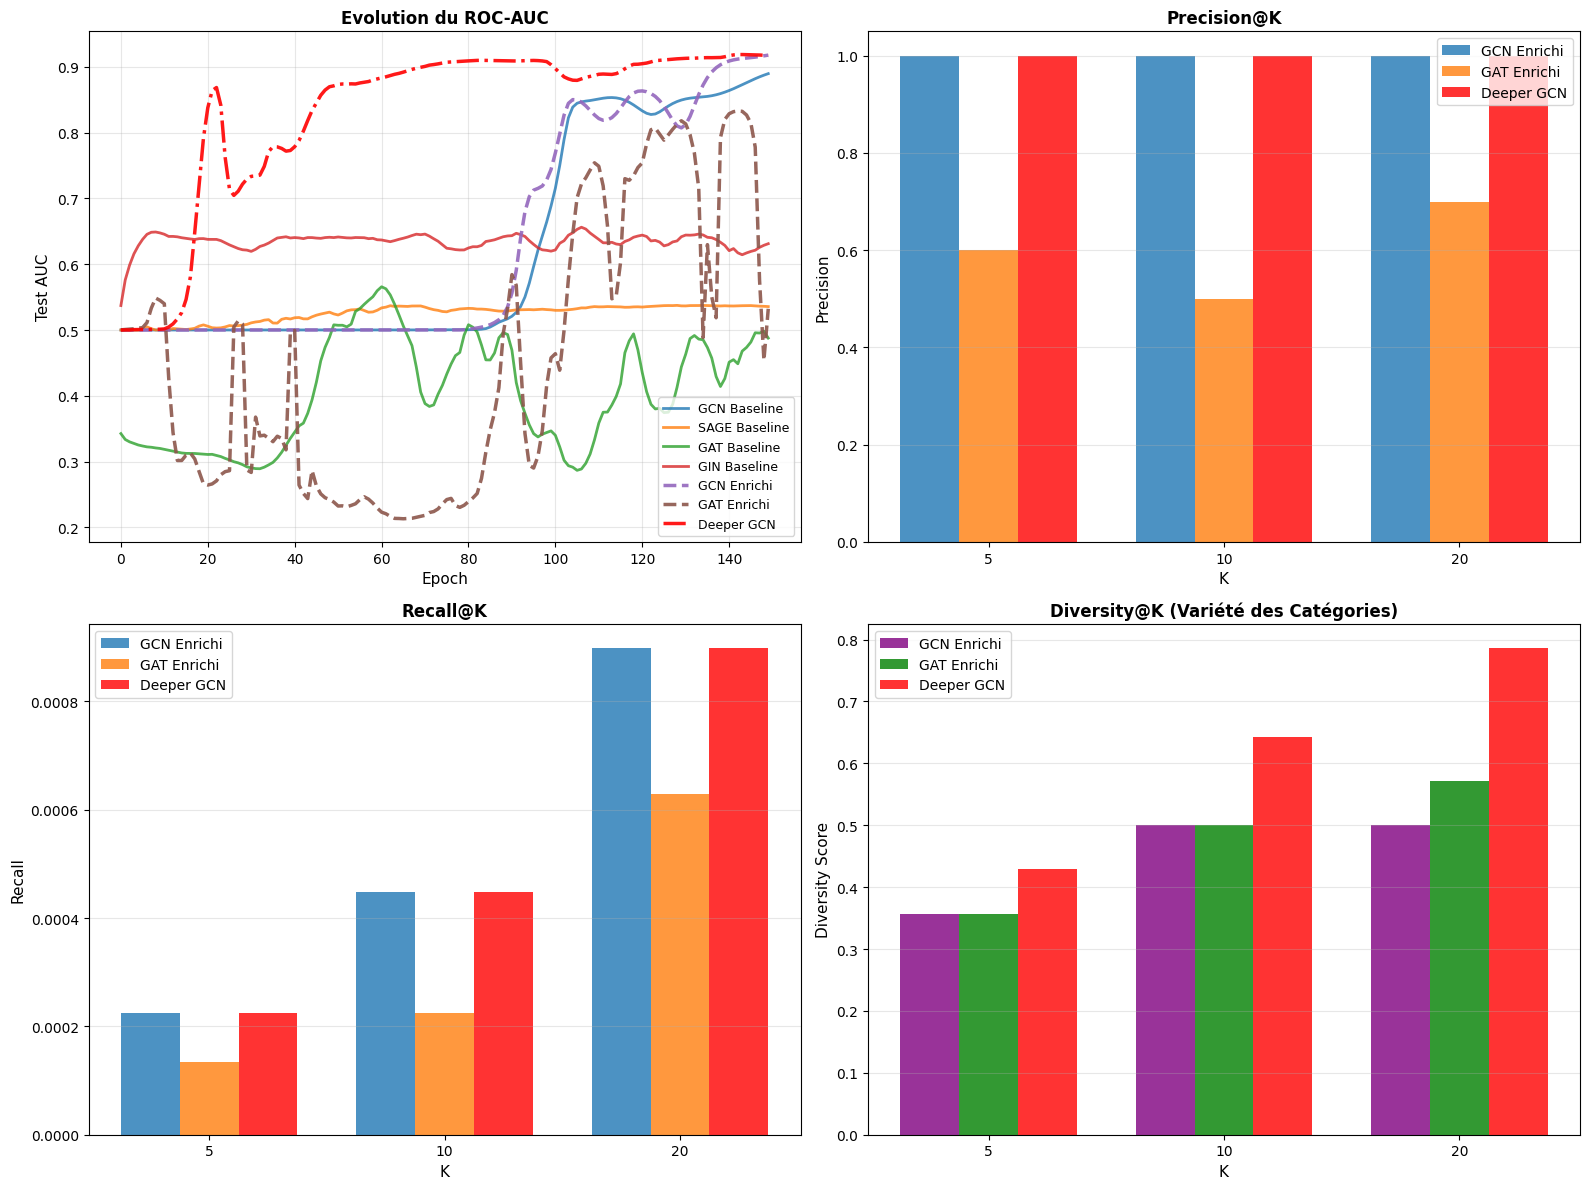


TABLEAU RÉCAPITULATIF FINAL - COMPARAISON DE TOUS LES MODÈLES
Modèle                    ROC-AUC      MRR          P@10         R@10         Div@10      
----------------------------------------------------------------------------------------------------
GCN Baseline              0.8896       N/A          N/A          N/A          N/A         
SAGE Baseline             0.5356       N/A          N/A          N/A          N/A         
GAT Baseline              0.4877       N/A          N/A          N/A          N/A         
GIN Baseline              0.6312       N/A          N/A          N/A          N/A         
GCN Enrichi               0.9178       1.0000       1.0000       0.0004       0.5000      
GAT Enrichi               0.5322       0.3333       0.5000       0.0002       0.5000      
Deeper GCN                0.9170       1.0000       1.0000       0.0004       0.6429      


In [54]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graphique 1 : Evolution du Test AUC
axes[0, 0].plot(np.arange(len(validationMetrics_GCN)), 
                np.array(validationMetrics_GCN)[:, 1], 
                label='GCN Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_SAGE)), 
                np.array(validationMetrics_SAGE)[:, 1], 
                label='SAGE Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_GAT)), 
                np.array(validationMetrics_GAT)[:, 1], 
                label='GAT Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_GIN)), 
                np.array(validationMetrics_GIN)[:, 1], 
                label='GIN Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_GCN_Enriched)), 
                np.array(validationMetrics_GCN_Enriched)[:, 1], 
                label='GCN Enrichi', linewidth=2.5, alpha=0.9, linestyle='--')
axes[0, 0].plot(np.arange(len(validationMetrics_GAT_Enriched)), 
                np.array(validationMetrics_GAT_Enriched)[:, 1], 
                label='GAT Enrichi', linewidth=2.5, alpha=0.9, linestyle='--')
axes[0, 0].plot(np.arange(len(validationMetrics_DeeperGCN)), 
                np.array(validationMetrics_DeeperGCN)[:, 1], 
                label='Deeper GCN', linewidth=2.5, alpha=0.9, linestyle='-.', color='red')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Test AUC', fontsize=11)
axes[0, 0].set_title('Evolution du ROC-AUC', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9, loc='lower right')
axes[0, 0].grid(alpha=0.3)

# Graphique 2 : Comparaison Precision@K
k_values = [5, 10, 20]
gcn_enriched_precision = [metrics_enriched[f'precision@{k}'] for k in k_values]
gat_enriched_precision = [metrics_gat_enriched[f'precision@{k}'] for k in k_values]
deeper_gcn_precision = [metrics_deeper_gcn[f'precision@{k}'] for k in k_values]

x = np.arange(len(k_values))
width = 0.25

axes[0, 1].bar(x - width, gcn_enriched_precision, width, label='GCN Enrichi', alpha=0.8)
axes[0, 1].bar(x, gat_enriched_precision, width, label='GAT Enrichi', alpha=0.8)
axes[0, 1].bar(x + width, deeper_gcn_precision, width, label='Deeper GCN', alpha=0.8, color='red')
axes[0, 1].set_xlabel('K', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision@K', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([f'{k}' for k in k_values])
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# Graphique 3 : Comparaison Recall@K
gcn_enriched_recall = [metrics_enriched[f'recall@{k}'] for k in k_values]
gat_enriched_recall = [metrics_gat_enriched[f'recall@{k}'] for k in k_values]
deeper_gcn_recall = [metrics_deeper_gcn[f'recall@{k}'] for k in k_values]

axes[1, 0].bar(x - width, gcn_enriched_recall, width, label='GCN Enrichi', alpha=0.8)
axes[1, 0].bar(x, gat_enriched_recall, width, label='GAT Enrichi', alpha=0.8)
axes[1, 0].bar(x + width, deeper_gcn_recall, width, label='Deeper GCN', alpha=0.8, color='red')
axes[1, 0].set_xlabel('K', fontsize=11)
axes[1, 0].set_ylabel('Recall', fontsize=11)
axes[1, 0].set_title('Recall@K', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'{k}' for k in k_values])
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3, axis='y')

# Graphique 4 : Comparaison Diversité@K
gcn_enriched_diversity = [metrics_enriched[f'diversity@{k}'] for k in k_values]
gat_enriched_diversity = [metrics_gat_enriched[f'diversity@{k}'] for k in k_values]
deeper_gcn_diversity = [metrics_deeper_gcn[f'diversity@{k}'] for k in k_values]

axes[1, 1].bar(x - width, gcn_enriched_diversity, width, label='GCN Enrichi', alpha=0.8, color='purple')
axes[1, 1].bar(x, gat_enriched_diversity, width, label='GAT Enrichi', alpha=0.8, color='green')
axes[1, 1].bar(x + width, deeper_gcn_diversity, width, label='Deeper GCN', alpha=0.8, color='red')
axes[1, 1].set_xlabel('K', fontsize=11)
axes[1, 1].set_ylabel('Diversity Score', fontsize=11)
axes[1, 1].set_title('Diversity@K (Variété des Catégories)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'{k}' for k in k_values])
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tableau récapitulatif final
print("\n" + "="*100)
print("TABLEAU RÉCAPITULATIF FINAL - COMPARAISON DE TOUS LES MODÈLES")
print("="*100)
print(f"{'Modèle':<25} {'ROC-AUC':<12} {'MRR':<12} {'P@10':<12} {'R@10':<12} {'Div@10':<12}")
print("-"*100)

# Créer le tableau récapitulatif
models_summary = [
    ("GCN Baseline", np.array(validationMetrics_GCN)[-1, 1], "N/A", "N/A", "N/A", "N/A"),
    ("SAGE Baseline", np.array(validationMetrics_SAGE)[-1, 1], "N/A", "N/A", "N/A", "N/A"),
    ("GAT Baseline", np.array(validationMetrics_GAT)[-1, 1], "N/A", "N/A", "N/A", "N/A"),
    ("GIN Baseline", np.array(validationMetrics_GIN)[-1, 1], "N/A", "N/A", "N/A", "N/A"),
    ("GCN Enrichi", metrics_enriched['roc_auc'], metrics_enriched['mrr'], 
     metrics_enriched['precision@10'], metrics_enriched['recall@10'], metrics_enriched['diversity@10']),
    ("GAT Enrichi", metrics_gat_enriched['roc_auc'], metrics_gat_enriched['mrr'], 
     metrics_gat_enriched['precision@10'], metrics_gat_enriched['recall@10'], metrics_gat_enriched['diversity@10']),
    ("Deeper GCN", metrics_deeper_gcn['roc_auc'], metrics_deeper_gcn['mrr'], 
     metrics_deeper_gcn['precision@10'], metrics_deeper_gcn['recall@10'], metrics_deeper_gcn['diversity@10']),
]

for model_name, auc, mrr, p10, r10, d10 in models_summary:
    auc_str = f"{auc:.4f}" if isinstance(auc, float) else auc
    mrr_str = f"{mrr:.4f}" if isinstance(mrr, float) else mrr
    p10_str = f"{p10:.4f}" if isinstance(p10, float) else p10
    r10_str = f"{r10:.4f}" if isinstance(r10, float) else r10
    d10_str = f"{d10:.4f}" if isinstance(d10, float) else d10
    print(f"{model_name:<25} {auc_str:<12} {mrr_str:<12} {p10_str:<12} {r10_str:<12} {d10_str:<12}")

print("="*100)

### Analyse de Convergence des Modèles

Visualisons la convergence de chaque modèle individuellement pour mieux comprendre leur comportement durant l'entraînement.

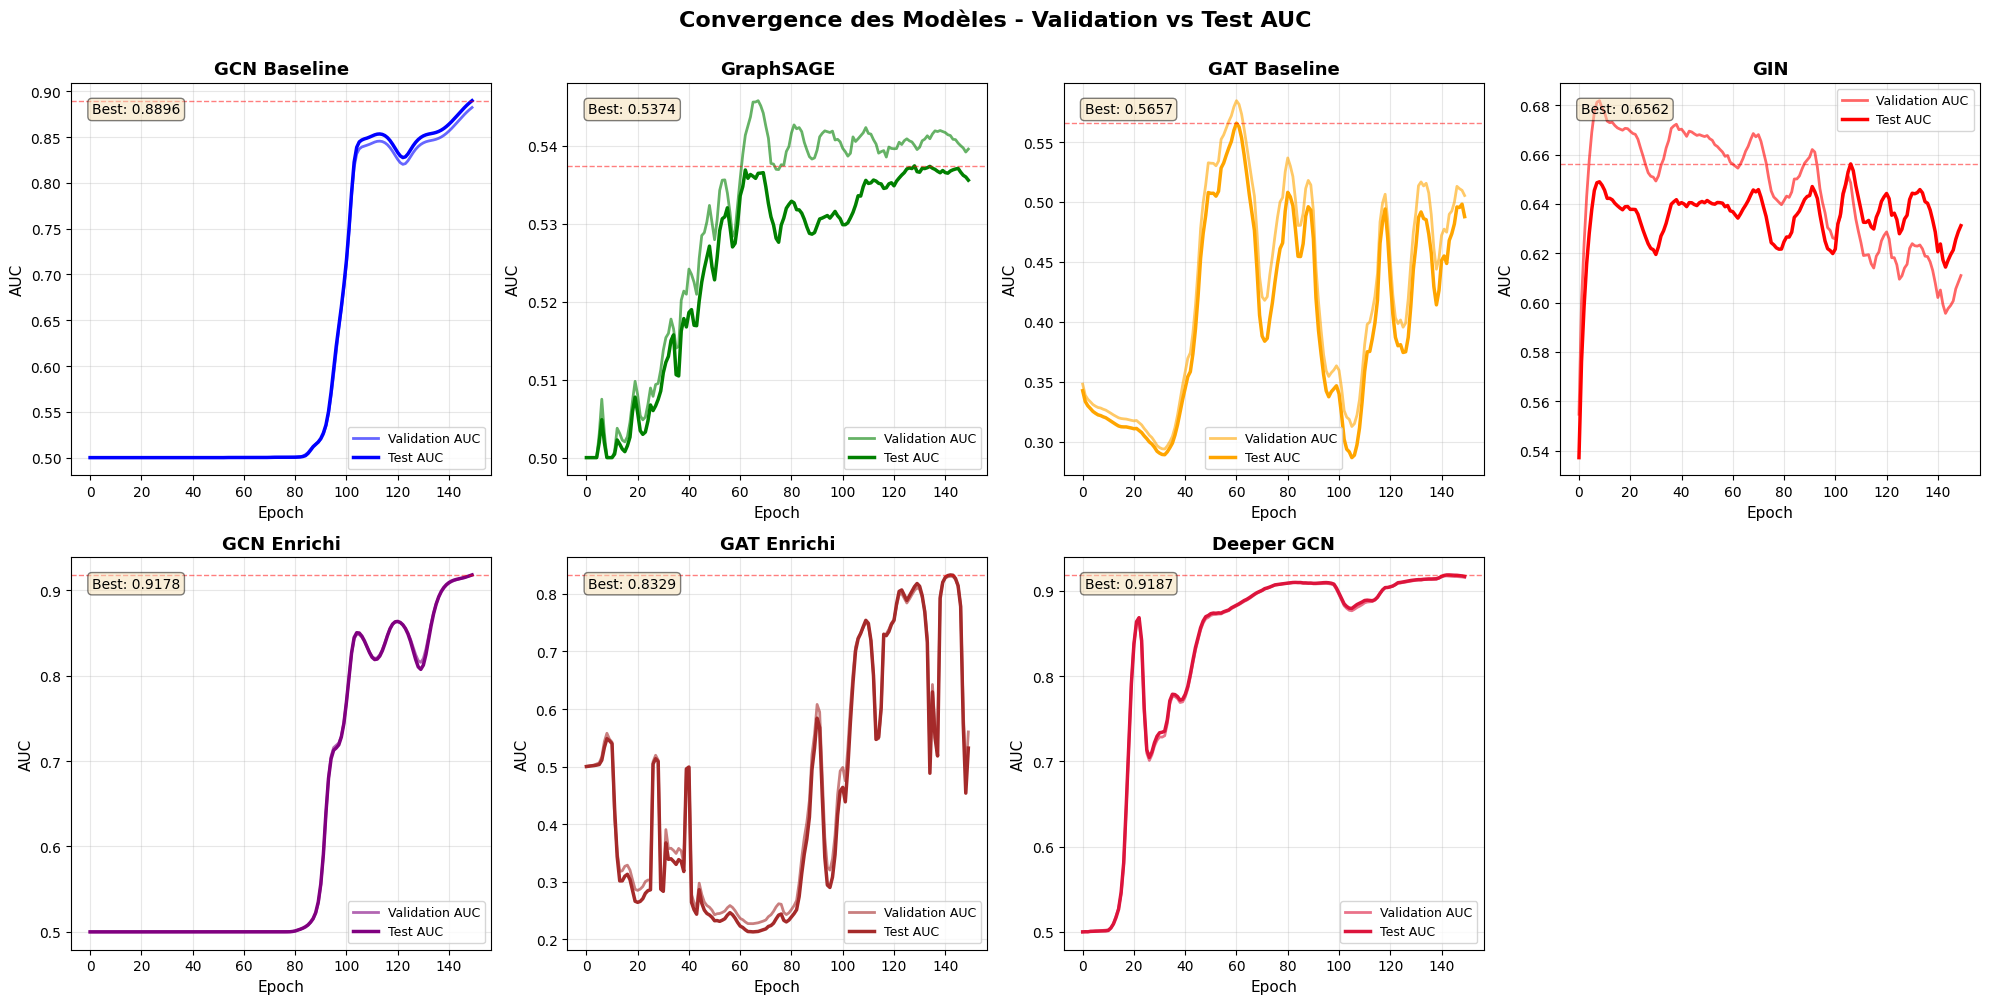

In [55]:
# Préparation des données pour l'analyse de convergence
models_data = [
    ("GCN Baseline", validationMetrics_GCN, 'blue'),
    ("GraphSAGE", validationMetrics_SAGE, 'green'),
    ("GAT Baseline", validationMetrics_GAT, 'orange'),
    ("GIN", validationMetrics_GIN, 'red'),
    ("GCN Enrichi", validationMetrics_GCN_Enriched, 'purple'),
    ("GAT Enrichi", validationMetrics_GAT_Enriched, 'brown'),
    ("Deeper GCN", validationMetrics_DeeperGCN, 'crimson'),
]

# Analyse de la convergence
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, metrics, color) in enumerate(models_data):
    ax = axes[idx]
    metrics_array = np.array(metrics)
    
    ax.plot(metrics_array[:, 0], label='Validation AUC', color=color, alpha=0.6, linewidth=2)
    ax.plot(metrics_array[:, 1], label='Test AUC', color=color, linewidth=2.5)
    
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('AUC', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Afficher le meilleur score
    best_test = metrics_array[:, 1].max()
    ax.axhline(y=best_test, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(0.05, 0.95, f'Best: {best_test:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Masquer le dernier subplot vide
axes[-1].axis('off')

plt.suptitle('Convergence des Modèles - Validation vs Test AUC', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Analyse: Complexité vs Performance

Analysons le compromis entre le nombre de paramètres du modèle et sa performance pour identifier les modèles les plus efficaces.


ANALYSE: Nombre de Paramètres vs Performance

Modèle               Paramètres      Test AUC     AUC/1k params
----------------------------------------------------------------------
GCN Baseline                8,512   0.8896      0.104517
GraphSAGE                  16,832   0.5356      0.031821
GAT Baseline               36,160   0.4877      0.013488
GIN                        29,952   0.6312      0.021073
GCN Enrichi                10,688   0.9178      0.085871
GAT Enrichi                44,864   0.5322      0.011863
Deeper GCN                 77,632   0.9170      0.011812


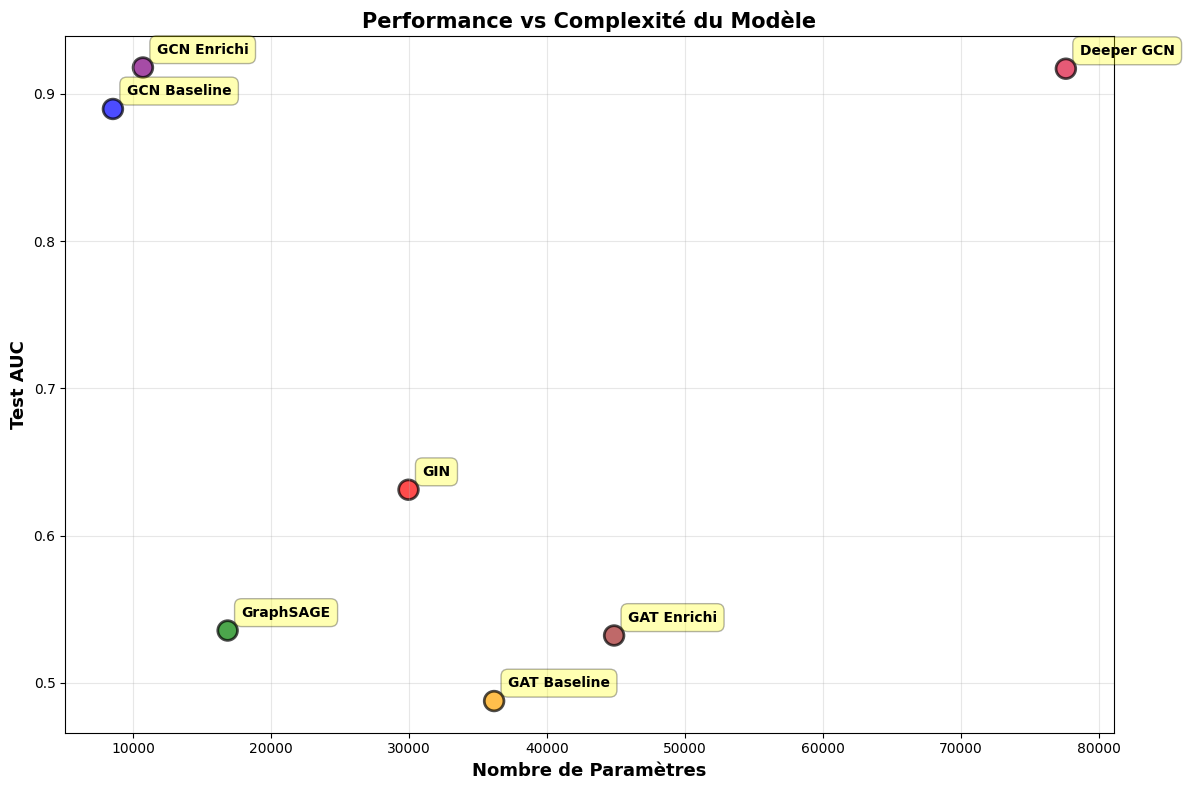

In [56]:
# Comparaison nombre de paramètres vs performance
model_list = [
    model_gcn,
    model_sage,
    model_gat,
    model_gin,
    model_enriched,
    model_gat_enriched,
    model_deeper_gcn
]
model_names = [
    "GCN Baseline",
    "GraphSAGE",
    "GAT Baseline",
    "GIN",
    "GCN Enrichi",
    "GAT Enrichi",
    "Deeper GCN"
]
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'crimson']

# Calculer le nombre de paramètres pour chaque modèle
params = [sum(p.numel() for p in m.parameters()) for m in model_list]

# Récupérer les meilleurs scores AUC depuis les validation metrics
aucs = [
    np.array(validationMetrics_GCN)[-1, 1],
    np.array(validationMetrics_SAGE)[-1, 1],
    np.array(validationMetrics_GAT)[-1, 1],
    np.array(validationMetrics_GIN)[-1, 1],
    np.array(validationMetrics_GCN_Enriched)[-1, 1],
    np.array(validationMetrics_GAT_Enriched)[-1, 1],
    np.array(validationMetrics_DeeperGCN)[-1, 1],
]

print("\n" + "="*70)
print("ANALYSE: Nombre de Paramètres vs Performance")
print("="*70)
print(f"\n{'Modèle':<20} {'Paramètres':<15} {'Test AUC':<12} {'AUC/1k params'}")
print("-"*70)

for name, param_count, auc in zip(model_names, params, aucs):
    efficiency = auc / (param_count / 1000)
    print(f"{name:<20} {param_count:>12,}   {auc:.4f}      {efficiency:.6f}")

print("="*70)

# Graphique scatter
plt.figure(figsize=(12, 8))
plt.scatter(params, aucs, c=colors, s=200, alpha=0.7, edgecolors='black', linewidth=2)

for i, name in enumerate(model_names):
    plt.annotate(name, (params[i], aucs[i]), 
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.xlabel('Nombre de Paramètres', fontsize=13, fontweight='bold')
plt.ylabel('Test AUC', fontsize=13, fontweight='bold')
plt.title('Performance vs Complexité du Modèle', fontsize=15, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Générateur de Recettes Interactif

Testons les différents modèles en générant des recommandations d'ingrédients à partir d'un ingrédient de départ.

In [72]:
# Créer une liste d'ingrédients indexée par les indices du graphe
# nodes_df est déjà trié par les indices du graphe (0, 1, 2, ...)
ingredient_list = nodes_df['name'].str.lower().tolist()

print(f"Nombre d'ingrédients dans la liste: {len(ingredient_list)}")
print(f"Exemples d'ingrédients: {ingredient_list[:5]}")

Nombre d'ingrédients dans la liste: 6653
Exemples d'ingrédients: ['1%_fat_buttermilk', '1%_fat_cottage_cheese', '10%_cream', '100%_bran', '10_inch_flour_tortilla']


In [77]:
# Calcul des probabilités d'arêtes pour GAT Enriched (si pas déjà fait)
if 'final_edge_probs_GAT_Enriched' not in locals():
    z_gat_enriched = model_gat_enriched.encode(test_data_enriched.x, test_data_enriched.edge_index)
    final_edge_probs_GAT_Enriched = model_gat_enriched.decode_all(z_gat_enriched)

# Dictionnaire des probabilités d'arêtes pour chaque modèle
edge_probs_dict = {
    "GCN Baseline": final_edge_probs_GCN,
    "GraphSAGE": final_edge_probs_SAGE,
    "GAT Baseline": final_edge_probs_GAT,
    "GIN": final_edge_probs_GIN,
    "GCN Enrichi": final_edge_probs_GCN_Enriched,
    "GAT Enrichi": final_edge_probs_GAT_Enriched,
    "Deeper GCN": final_edge_probs_DeeperGCN_all,
}

def generate_recipe_simple(start_ingredient, edge_probs_dict, k=10, max_steps=6):
    """
    Génère des recettes en utilisant les probabilités d'arêtes pré-calculées.
    Similaire à la méthode originale avec GraphSAGE.
    
    Args:
        start_ingredient: Nom de l'ingrédient de départ
        edge_probs_dict: Dictionnaire {nom_modèle: matrice_probabilités}
        k: Nombre de top prédictions à considérer
        max_steps: Nombre maximum d'étapes
    
    Returns:
        dict: {nom_modèle: liste_ingredients}
    """
    # Trouver l'index de l'ingrédient de départ
    try:
        start_idx = ingredient_list.index(start_ingredient.lower())
    except ValueError:
        print(f"Ingrédient '{start_ingredient}' non trouvé.")
        return {}
    
    recipes = {}
    
    for model_name, edge_probs in edge_probs_dict.items():
        recipe = [start_ingredient.lower()]
        current_node = start_idx
        
        for step in range(1, max_steps):
            # Obtenir les top-K prédictions pour le nœud actuel
            top_nodes = nodes_df.iloc[edge_probs.topk(k, dim=1).indices[current_node, ]]
            
            # Choisir aléatoirement parmi les top-K
            which_one = np.random.randint(0, k)
            current_node = top_nodes.iloc[which_one].name
            
            recipe.append(top_nodes.iloc[which_one]['name'])
        
        recipes[model_name] = recipe
    
    return recipes


# Fonction d'affichage
def display_recipe_comparison(start_ingredient, recipes):
    """Affiche les recettes de manière formatée."""
    print("\n" + "="*70)
    print("GÉNÉRATION DE RECETTES PAR MODÈLE")
    print("="*70)
    print(f"\n🍳 Ingrédient de départ: {start_ingredient.upper()}")
    print("-"*70)
    
    for model_name, ingredients in recipes.items():
        recipe_str = " → ".join(ingredients)
        print(f"\n{model_name:<15}: {recipe_str}")
    
    print("\n" + "="*70)


# Tester avec différents ingrédients
test_ingredients = ["CHEESE", "BEEF", "CHOCOLATE", "GARLIC", "TOMATO"]

for ingredient in test_ingredients:
    recipes = generate_recipe_simple(
        ingredient, 
        edge_probs_dict, 
        k=10, 
        max_steps=6
    )
    
    if recipes:
        display_recipe_comparison(ingredient, recipes)


GÉNÉRATION DE RECETTES PAR MODÈLE

🍳 Ingrédient de départ: CHEESE
----------------------------------------------------------------------

GCN Baseline   : cheese → butter → olive_oil → carrot → egg → egg

GraphSAGE      : cheese → biscuit_dough → 100%_bran → 1%_fat_cottage_cheese → 2%_cheddar_cheese → 10_inch_flour_tortilla

GAT Baseline   : cheese → chai_tea_mix → chai_tea_mix → arm_roast → beef_gravy_mix → bird_seed

GIN            : cheese → 85%_lean_ground_beef → 1%_fat_buttermilk → 2%_cheddar_cheese → 100%_bran → 8_inch_flour_tortilla

GCN Enrichi    : cheese → egg → baking_powder → bay_leaf → brown_sugar → all_purpose_flour

GAT Enrichi    : cheese → walleye → white_dinner_roll → caramel_square → butter → caramel_square

Deeper GCN     : cheese → apple_cider → apple → american_cheese → baking_powder → almond_butter


GÉNÉRATION DE RECETTES PAR MODÈLE

🍳 Ingrédient de départ: BEEF
----------------------------------------------------------------------

GCN Baseline   : beef → salt

## Conclusion : Améliorations Apportées

Ce notebook représente une évolution par rapport au travail de base présent dans `Link_Prediction_on_Heterogenous_Graphs_with_PyG.ipynb`. 
Voici un récapitulatif des améliorations implémentées :

### Enrichissement des Features

**Features Structurelles :**
- **Degré des nœuds** : capture l'importance relative de chaque ingrédient dans le réseau
- **Normalisation avancée** : standardisation des features pour améliorer la convergence

**Features Chimiques :**
- **Composés chimiques** : intégration du nombre de composés liés à chaque ingrédient pour capturer les similarités moléculaires
- **Relations entity-compound** : exploitation des liens ingrédient-composé du FlavorGraph complet

**Features Catégorielles :**
- **Classification par mots-clés** : 7 catégories (viandes, poissons, légumes, fruits, épices, produits laitiers, autres)
- **Embeddings catégoriels** : one-hot encoding pour enrichir la représentation des nœuds

### Nouveaux Modèles Testés

**1. GAT (Graph Attention Network)** :
- Mécanisme d'attention multi-têtes (4 heads) pour pondérer dynamiquement l'importance des voisins

**2. GIN (Graph Isomorphism Network)** :
- Architecture basée sur le test de Weisfeiler-Lehman

**3. DeeperGCN** :
- Architecture profonde (4 couches) avec connexions résiduelles (skip connections)


**4. Modèles Enrichis** :
- **EnrichedNet (GCN)** : GCN utilisant les features enrichies
- **EnrichedGAT** : GAT avec features enrichies pour combiner attention et informations supplémentaires

### Métriques d'Évaluation Avancées

Au-delà du simple ROC-AUC du modèle de base :

**Métriques de Ranking :**
- **Precision@K** : précision dans les top-K prédictions (K=5, 10, 20)
- **Recall@K** : couverture des vraies arêtes dans les top-K
- **MRR (Mean Reciprocal Rank)** : position moyenne de la première prédiction correcte

**Métriques de Qualité :**
- **Diversity@K** : variété des catégories d'ingrédients dans les prédictions
- Permet d'évaluer si les modèles proposent des combinaisons créatives et équilibrées
